In [2]:
import os
from typing import Any, Callable, Iterable, List, Optional, Tuple, Union
from tqdm import tqdm
import numpy as np
import pickle
import torchvision.transforms as T
import SimpleITK as sitk
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
def reslice_image(input_image, reference_spacing, is_label_map=False):
    """
    Point 1: Reslicing
    """
    # I/P image statistics
    input_size = input_image.GetSize()
    input_spacing = input_image.GetSpacing()
    input_direction = input_image.GetDirection()
    input_origin = input_image.GetOrigin()
    
    # The size of the output image is adjusted to account for changes in the output spacing, in order to preserve the anatomical structure of the image.
    output_size = [round(input_size[dim] * (input_spacing[dim] / reference_spacing[dim])) for dim in range(3)]
    
    # Resample Filter
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(output_size)
    resampler.SetOutputSpacing(reference_spacing)
    resampler.SetOutputDirection(input_direction)
    resampler.SetOutputOrigin(input_origin)
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(input_image.GetPixelIDValue())

    # BSpline Interploation
    if is_label_map:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resampler.SetInterpolator(sitk.sitkBSpline)

    output_image = sitk.GetArrayFromImage(resampler.Execute(input_image))
    
    return output_image

def crop_image(output_image):
    """
    Point 2: Cropping
    """
    z_dim, x_dim, y_dim = output_image.shape
    output_image = output_image[z_dim//2-8:z_dim//2+8, x_dim//2-150: x_dim//2 + 150,  y_dim//2 - 150: y_dim//2 + 150]
    
    return output_image

def extract_slices2D(image3D):
    """
    Point 3: 2D slices
    """
    slices2D = np.split(image3D, 16, axis=0)
    
    return slices2D

def augmentation(image_array, mask_array):
    """"""
    flipped_img = np.fliplr(image_array)
    flipped_mask = np.fliplr(mask_array)
    
    return flipped_img, flipped_mask

def normalization(img):
    mean = np.mean(img)
    std = np.std(img)
    if std==0:
        std=1e-8
    img = (img-mean)/std
    return img

def IMAGE_PIPELINE(img_path, label_path, ref_spacing):
    
    image3D = sitk.ReadImage(img_path)
    image3D = reslice_image(image3D, ref_spacing, False)
    image3D = crop_image(image3D)
    
    target3D = sitk.ReadImage(label_path)
    target3D = reslice_image(target3D, ref_spacing, True)
    target3D = crop_image(target3D)
    
    #flipped_images, flipped_targets = augmentation(image3D, target3D)
    
    slices = extract_slices2D(image3D)
    target_masks = extract_slices2D(target3D)
    
    SLICES = []
    TARGETS = []
    
    for i in range(len(slices)):
        
        img_slice = normalization(slices[i])
        mask_slice = target_masks[i]
        
        flipped_slice, flipped_mask = augmentation(img_slice, mask_slice)
        SLICES.append(img_slice)
        SLICES.append(flipped_slice)
        TARGETS.append(mask_slice)
        TARGETS.append(flipped_mask)

    #SLICES.extend(slices)
    #TARGETS.extend(target_masks)
    
    return SLICES, TARGETS

In [4]:
def SAVE_PROCESSED_FOLDS(
    fold, 
    REF_SPACING, 
    TASK,
    LESION_PATH = "picai_labels/csPCa_lesion_delineations/AI/Bosma22a/",
    PROSTATE_PATH = "picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/"
):
    
    #os.makedirs(f"TASK-{TASK}/FOLD{fold}/images/", exist_ok=True)
    #os.makedirs(f"TASK-{TASK}/FOLD{fold}/masks/", exist_ok=True)
    
    if TASK == "A":

        type_of_volume="t2w" 
        type_of_mask="PROSTATE"
    
    elif TASK == "B":

        type_of_volume="adc"
        type_of_mask="LESION"
    
    elif TASK == "C":

        type_of_volume="hbv"
        type_of_mask="LESION"

    IDS = os.listdir(f"FOLD{fold}")
    
    input_images = []
    target_masks = []
    
    for ID in tqdm(IDS):
        img_filename = [x for x in os.listdir(f"FOLD{fold}/" + ID) if type_of_volume in x][0]
        #print(img_filename)
        identifier = img_filename.replace(f"_{type_of_volume}.mha", "")
        #print(identifier)
        img_path = f"FOLD{fold}/" + ID + "/" + img_filename
        #print(img_path)
        if type_of_mask == "PROSTATE":
            label_path = PROSTATE_PATH + [x for x in os.listdir(PROSTATE_PATH) if identifier in x][0]
        elif type_of_mask == "LESION":
            label_path = LESION_PATH + [x for x in os.listdir(LESION_PATH) if identifier in x][0]
        #print(label_path)

        input_slices, target_slices = IMAGE_PIPELINE(img_path, label_path, REF_SPACING)
        
        for i in range(len(input_slices)):
            
            input_images.append(input_slices[i]) #.reshape(300, 300).save(f"TASK-{TASK}/FOLD{fold}/images/{ID}_{identifier}.png") 
            target_masks.append(target_slices[i]) #.reshape(300, 300)).save(f"TASK-{TASK}/FOLD{fold}/masks/{ID}_{identifier}.png") 
    
    with open(f"TASK-{TASK}/fold{fold}_images.npy", 'wb') as f:

        np.save(f, np.concatenate(input_images))

    with open(f"TASK-{TASK}/fold{fold}_masks.npy", 'wb') as f:

        np.save(f, np.concatenate(target_masks))

    print(f"\n SAVED TASK {TASK} FOLD {fold} in .npy format!\n")

In [5]:
REF_SPACING = (0.5, 0.5, 3.0)

In [6]:
#for TASK in ["A", "B", "C"]:
#    for FOLD in range(5):
#        SAVE_PROCESSED_FOLDS(
#            FOLD,
#            REF_SPACING,
#            TASK,
#        )

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [8]:
# Source: https://github.com/clemkoa/u-net/blob/master/unet/unet.py

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet_2level(nn.Module):
    def __init__(self):
        super(UNet_2level, self).__init__()
        self.conv1 = double_conv(1, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.up1 = up_layer(256, 128)
        self.up2 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x1_up = self.up1(x2, x3)
        x2_up = self.up2(x1, x1_up)
        output = self.last_conv(x2_up)
        output = nn.Sigmoid()(output)
        return output

class UNet_3level(nn.Module):
    def __init__(self):
        super(UNet_3level, self).__init__()
        self.conv1 = double_conv(1, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.up1 = up_layer(512, 256)
        self.up2 = up_layer(256, 128)
        self.up3 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x1_up = self.up1(x3, x4)
        x2_up = self.up2(x2, x1_up)
        x3_up = self.up3(x1, x2_up)
        output = self.last_conv(x3_up)
        output = nn.Sigmoid()(output)
        return output

class UNet_4level(nn.Module):
    def __init__(self):
        super(UNet_4level, self).__init__()
        self.conv1 = double_conv(1, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x1_up = self.up1(x4, x5)
        x2_up = self.up2(x3, x1_up)
        x3_up = self.up3(x2, x2_up)
        x4_up = self.up4(x1, x3_up)
        output = self.last_conv(x4_up)
        output = nn.Sigmoid()(output)
        return output

In [9]:
class SegmentationDataset(Dataset):
    
    def __init__(self, TASK, FOLDS):
        
        imgs_list = []
        msks_list = []
        for fold in FOLDS:
            with open(f"TASK-{TASK}/fold{fold}_images.npy", "rb") as f:
                images = np.load(f)
            with open(f"TASK-{TASK}/fold{fold}_masks.npy", "rb") as f:
                masks = np.load(f)
            
            imgs_list.append(images)
            msks_list.append(masks)
            
        self.images = np.concatenate(imgs_list)
        self.masks = np.concatenate(msks_list)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        image = self.images[index]
        mask = self.masks[index]
        
        return image, mask

In [10]:
def get_dice(pred, target, smooth = 1.):
    """
    Source: https://github.com/usuyama/pytorch-unet/blob/master/loss.py
    """
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    dice_score = ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    
    return dice_score

def dice_loss(pred, target, smooth = 1.):
    
    loss = 1 - get_dice(pred, target, smooth)
    
    return loss.mean()

In [11]:
def train_and_evaluate_on_task(
    task, 
    unet_size=3, 
    N_EPOCHS = 100, 
    lr=2e-4, 
    batch_size=16, 
    patience_limit=10,
    ablation=False
):

    train_dataset = SegmentationDataset(task, [1, 2, 4])
    valid_dataset = SegmentationDataset(task, [3])
    test_dataset = SegmentationDataset(task, [0])
    
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)
    
    device = "cuda:2"
    
    if unet_size == 2:
        unet = UNet_2level().to(device)
    
    elif unet_size == 3:
        unet = UNet_3level().to(device)
    
    elif unet_size == 4:
        unet = UNet_4level().to(device)

    ## Setup Multi-GPU data parallelism (3 x RTX 2080 Ti)
    #unet = nn.DataParallel(unet)

    optim = torch.optim.AdamW(unet.parameters(), lr=lr)

    best_loss = 0.
    patience = 0
    
    train_losses = []
    valid_losses = []

    for i in range(N_EPOCHS):

        print(f"\n****************** Epoch - {i} *******************\n\n")
        unet.train()
        pbar = tqdm(train_loader)
        
        train_loss_sum = 0.
        count = 0
        
        print(f"\nTRAINING starts!\n")
        
        for x_img, y_mask in pbar:

            optim.zero_grad()
            x_img = x_img.unsqueeze(1).float().to(device)
            y_mask = y_mask.unsqueeze(1).float().to(device)

            y_pred = unet(x_img)

            loss = dice_loss(y_pred, y_mask)
            
            # We have to use mean of loss, as nn.DataParallel returns a list of losses per GPU
            loss.mean().backward() 

            pbar.set_description(f"training loss: {loss.mean().item():.4f}")

            optim.step()
            
            train_loss_sum += loss.item()
            count += 1
            
        train_losses.append(round((train_loss_sum / count), 3))

        unet.eval()
        print(f"\nVALIDATION starts!\n")
        with torch.no_grad():

            pbar = tqdm(valid_loader)

            val_loss_sum = 0.
            count = 0

            for x_img, y_mask in pbar:

                optim.zero_grad()
                x_img = x_img.unsqueeze(1).float().to(device)
                y_mask = y_mask.unsqueeze(1).float().to(device)

                y_pred = unet(x_img)

                loss = dice_loss(y_pred, y_mask)

                val_loss_sum += loss.mean().item()
                count+=1

                pbar.set_description(f"validation loss: {(val_loss_sum / count) :.4f}")
                
            valid_losses.append(round((val_loss_sum / count), 3))
            
            plt.plot(train_losses, label="training", color="red")
            plt.plot(valid_losses, label="validation", color="green")
            plt.legend(loc="upper right")
            plt.title(f'Training vs Validation loss until epoch {i}')
            plt.xlabel('Training step')
            plt.ylabel('Dice loss')
            plt.show()
            
            # Custom simple implementation of early stopping
            if (val_loss_sum / count) >= best_loss:

                best_loss = (val_loss_sum / count)

                #torch.save(unet.module.state_dict(), f"checkpoints/UNET_task{task}.pth")

            else:
                if patience < patience_limit:
                
                    patience += 1
                
                else:

                    print("Validation loss degraded after patience limit! Stopping training")
                    break    
                    
    
    print("\n*************** STARTING EVALUATION ***************\n")
    
    unet.eval()
    
    with torch.no_grad():
        
        print(f"\nEvaluation on TEST set!\n")
    
        pbar = tqdm(test_loader)

        test_dice_sum = 0.
        count = 0

        for x_img, y_mask in pbar:

            x_img = x_img.unsqueeze(1).float().to(device)
            y_mask = y_mask.unsqueeze(1).float().to(device)

            y_pred = unet(x_img)

            dice_value = get_dice(y_pred, y_mask)

            test_dice_sum += dice_value.mean().item()
            count+=1
            
        print(f"\n Dice score on test set: {(test_dice_sum / count) :.4f}\n")
    
        print(f"\n\n\nEvaluation on VALIDATION set!\n")
    
        pbar = tqdm(valid_loader)

        valid_dice_sum = 0.
        count = 0

        for x_img, y_mask in pbar:

            x_img = x_img.unsqueeze(1).float().to(device)
            y_mask = y_mask.unsqueeze(1).float().to(device)

            y_pred = unet(x_img)

            dice_value = get_dice(y_pred, y_mask)

            valid_dice_sum += dice_value.mean().item()
            count+=1
            
        print(f"\n Dice score on validation set: {valid_dice_sum / count}")
        
        print(f"\n\n\nEvaluation on TRAIN set!\n")
    
        pbar = tqdm(train_loader)

        train_dice_sum = 0.
        count = 0

        for x_img, y_mask in pbar:

            x_img = x_img.unsqueeze(1).float().to(device)
            y_mask = y_mask.unsqueeze(1).float().to(device)

            y_pred = unet(x_img)

            dice_value = get_dice(y_pred, y_mask)

            train_dice_sum += dice_value.mean().item()
            count+=1
            
        print(f"\n Dice score on train set: {train_dice_sum / count}")
    
    if ablation == True:
        
        return unet


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2479: 100%|████████████████████████████████████████████████████████████| 591/591 [04:39<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.3839: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


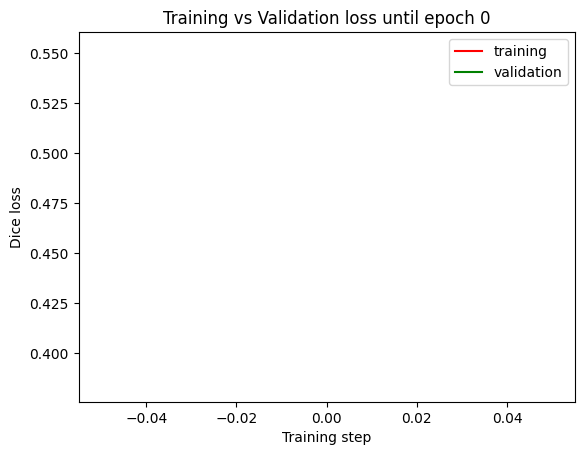


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2412: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2330: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.10it/s]


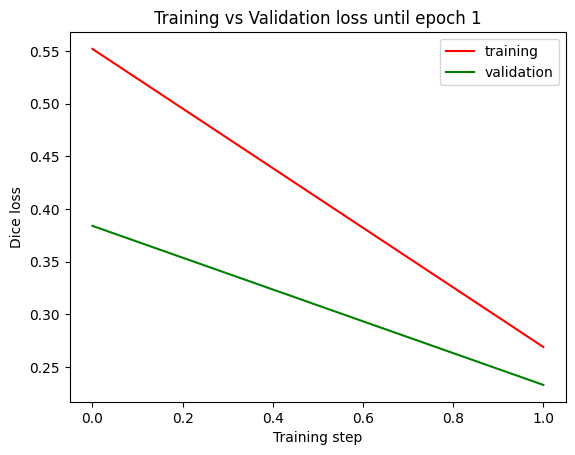


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1593: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2193: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


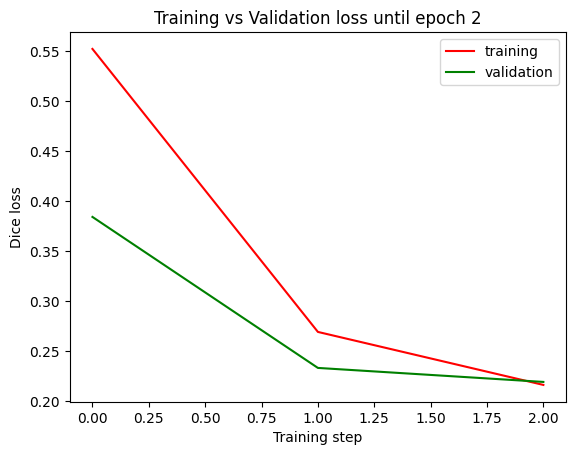


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1572: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1960: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


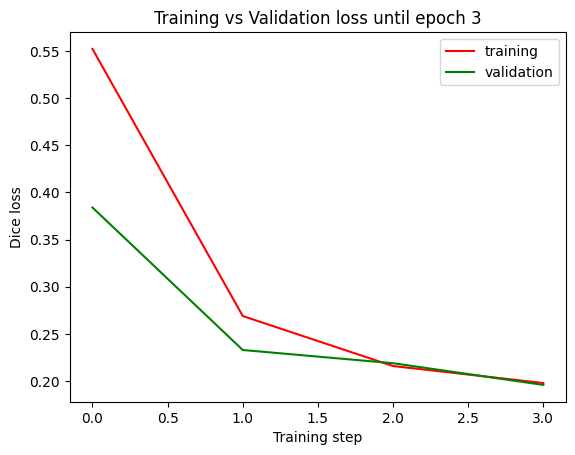


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2625: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1952: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


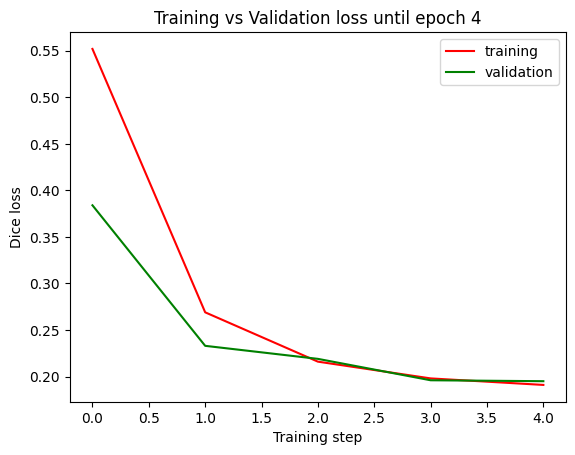


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2784: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.6572: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


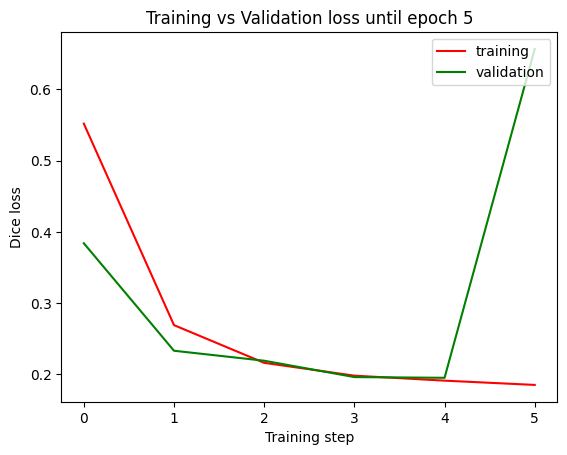


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2839: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.4071: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


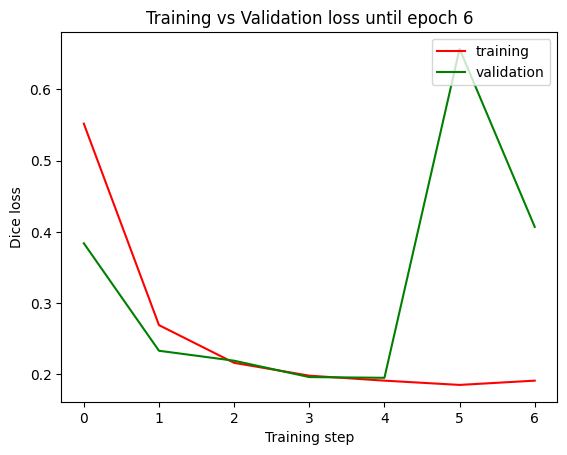


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3229: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2457: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


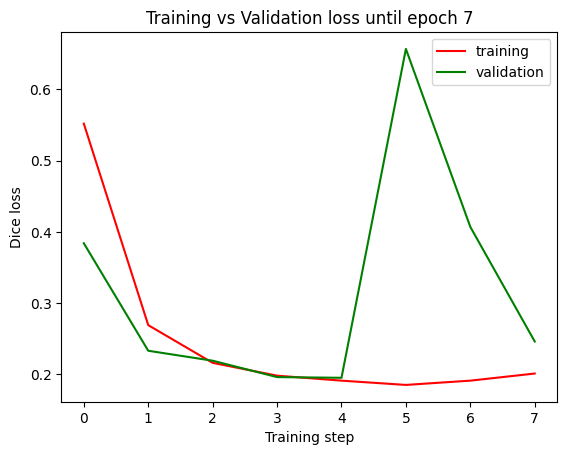


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1721: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.3147: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


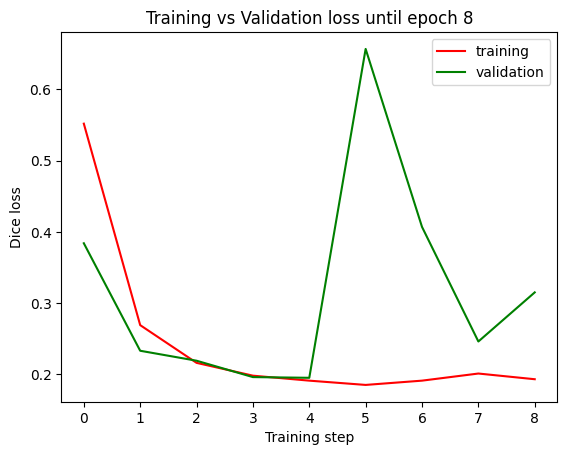


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2978: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1817: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


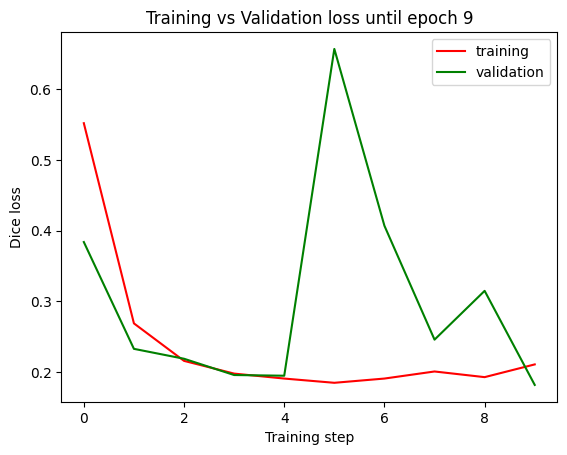


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1132: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1623: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


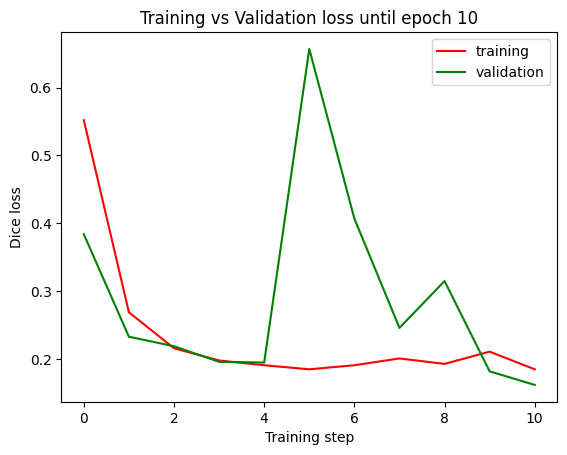


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1583: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1656: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


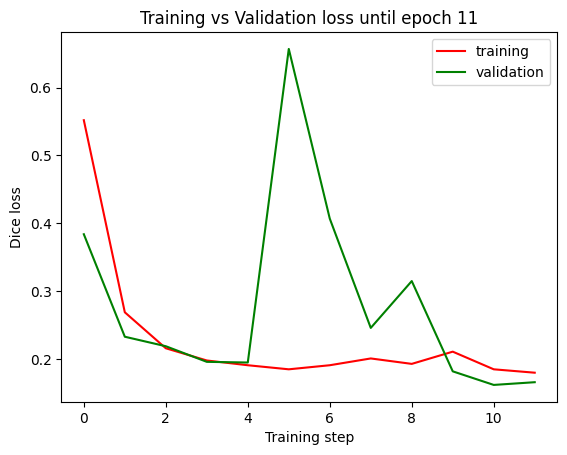


****************** Epoch - 12 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1449: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1591: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


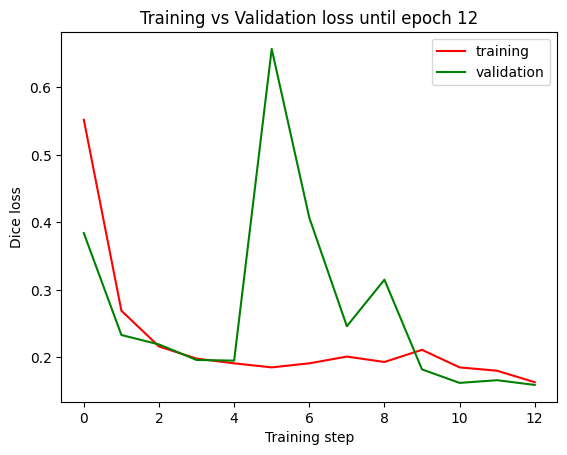

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.11it/s]



 Dice score on test set: 0.8348




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.11it/s]



 Dice score on validation set: 0.8410122881686022



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:35<00:00,  6.20it/s]



 Dice score on train set: 0.8486810104697691


In [7]:
train_and_evaluate_on_task("A")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9709: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.9687: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


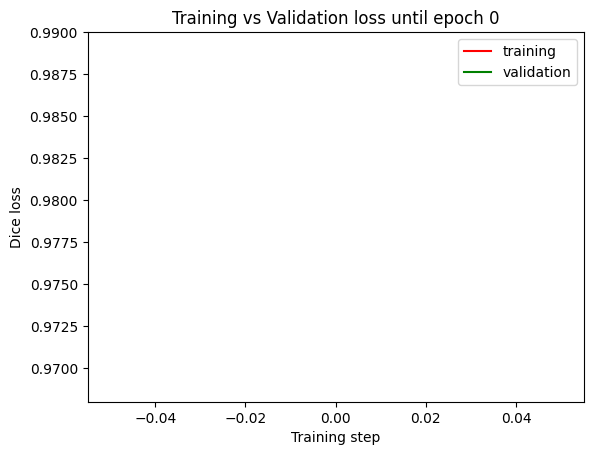


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.4958: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.4573: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


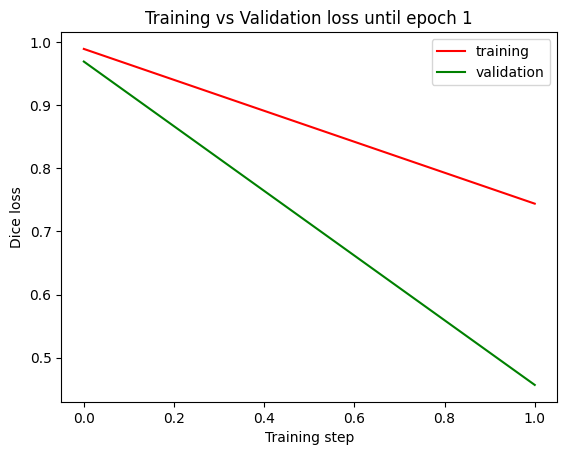


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3523: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.4036: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


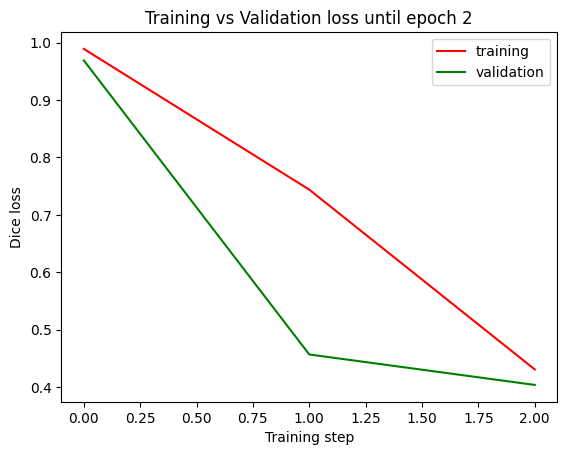


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3182: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2450: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


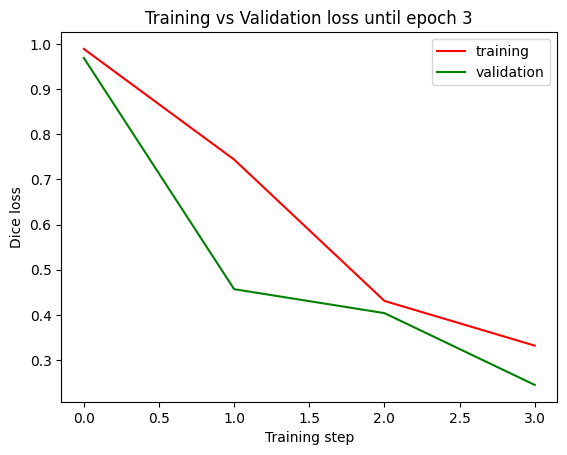


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1268: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0858: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


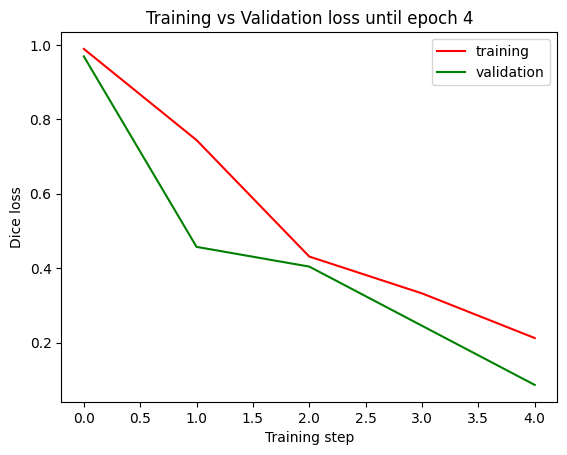


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0949: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0837: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


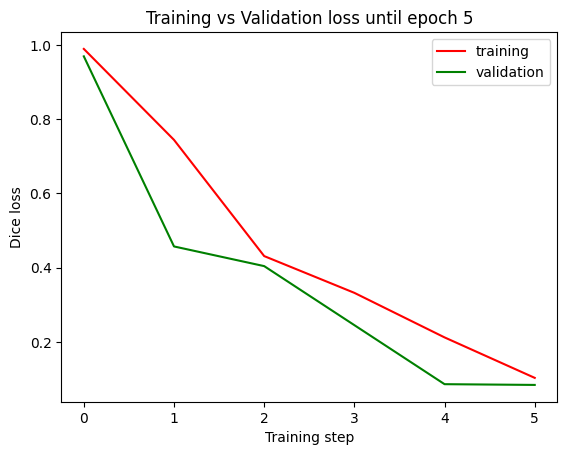


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0934: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0833: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


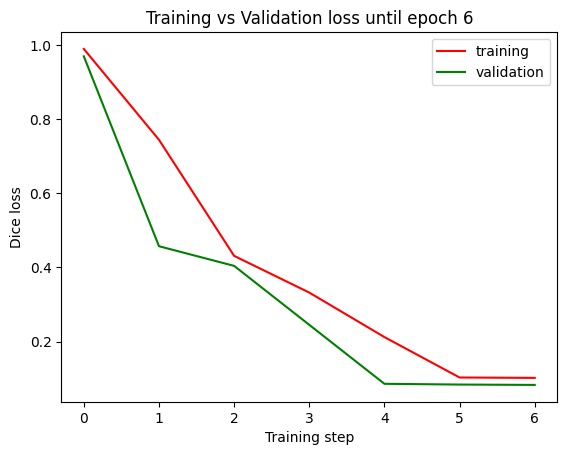


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1872: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0832: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.10it/s]


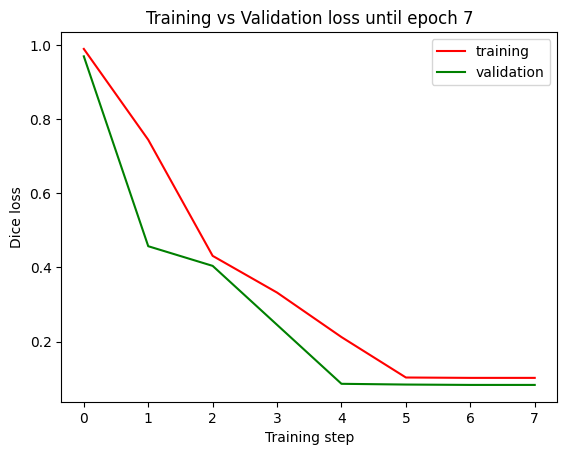


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1793: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


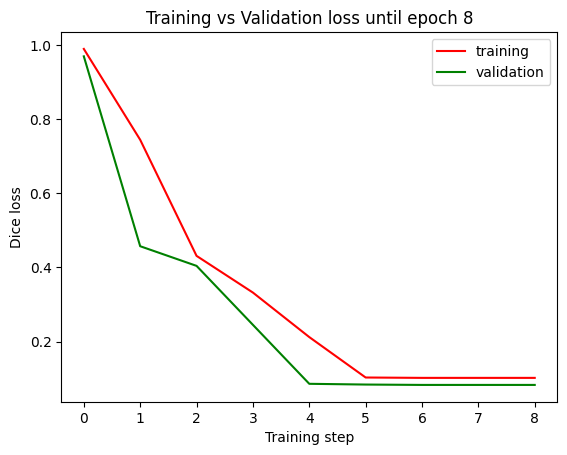


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0625: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


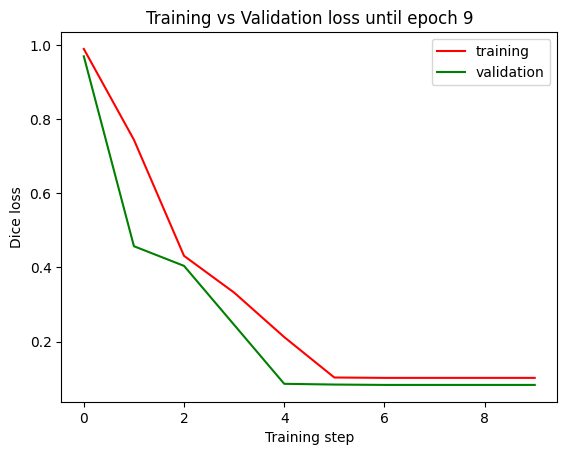


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0929: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0830: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


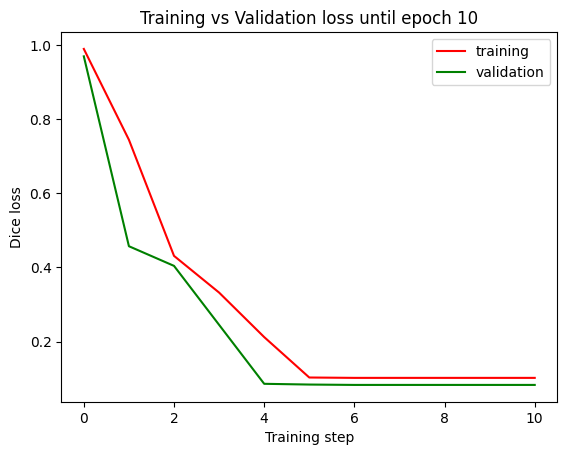


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0312: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0829: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.06it/s]


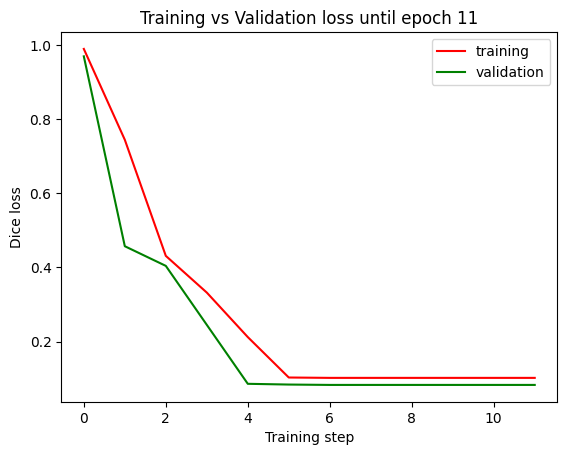

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.10it/s]



 Dice score on test set: 0.8986




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.09it/s]



 Dice score on validation set: 0.9169428200286052



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:36<00:00,  6.10it/s]



 Dice score on train set: 0.8983736051319012


In [8]:
train_and_evaluate_on_task("B")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9988: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.9847: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.04it/s]


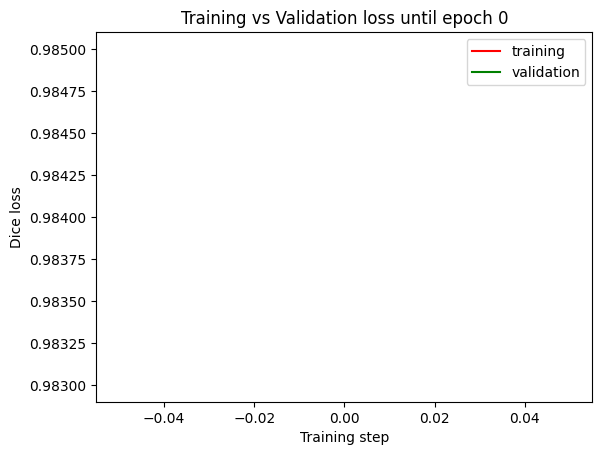


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6715: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.5776: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


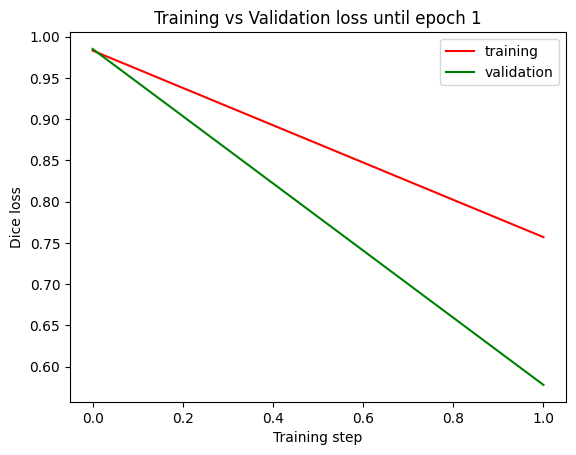


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5838: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.4243: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


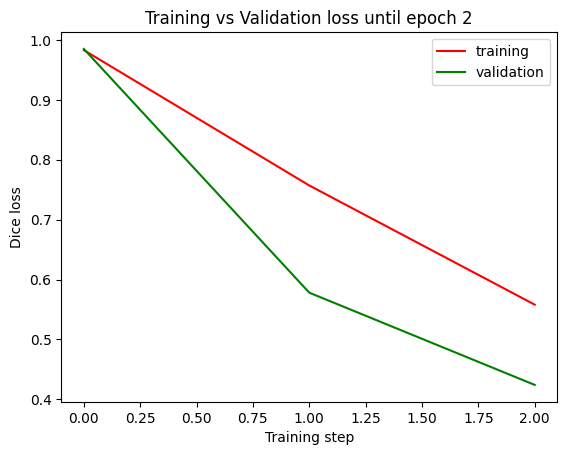


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0965: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0895: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


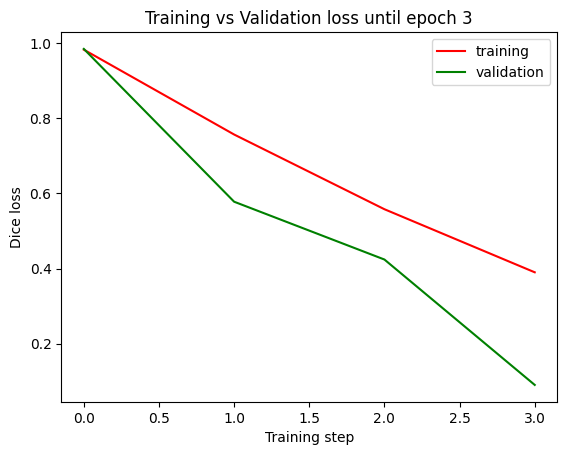


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1254: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0862: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


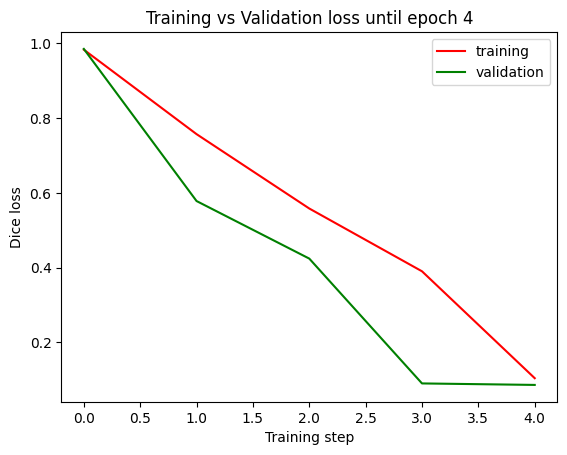


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0925: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0861: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.06it/s]


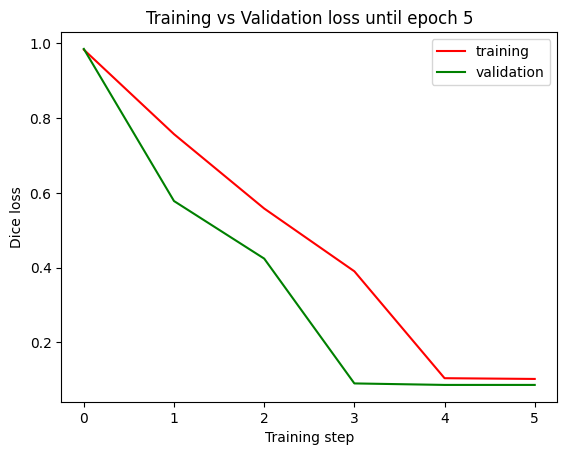


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1875: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0857: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


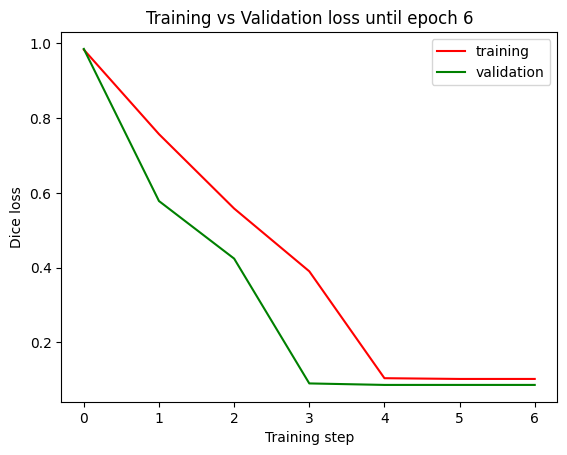


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0625: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0855: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.06it/s]


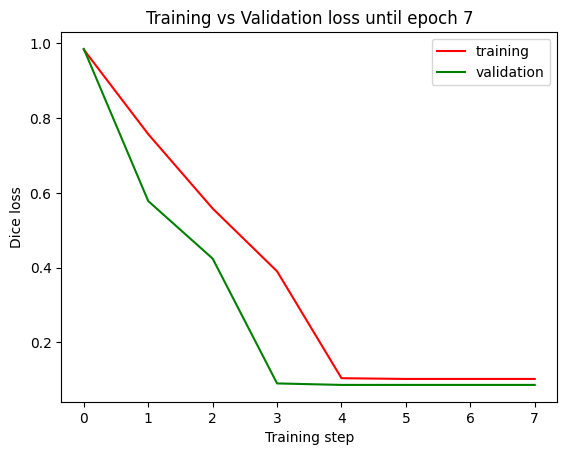


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1248: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0858: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.04it/s]


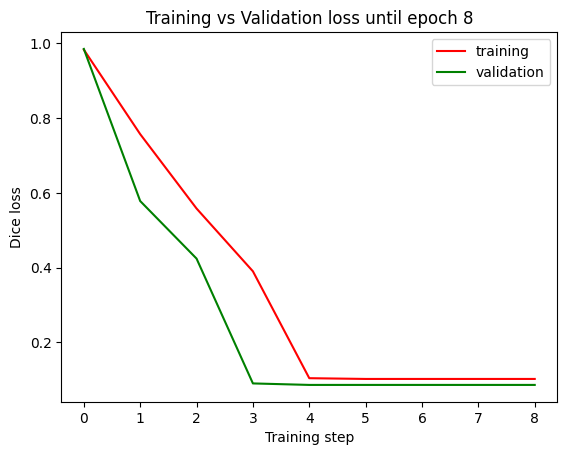


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1556: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0855: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


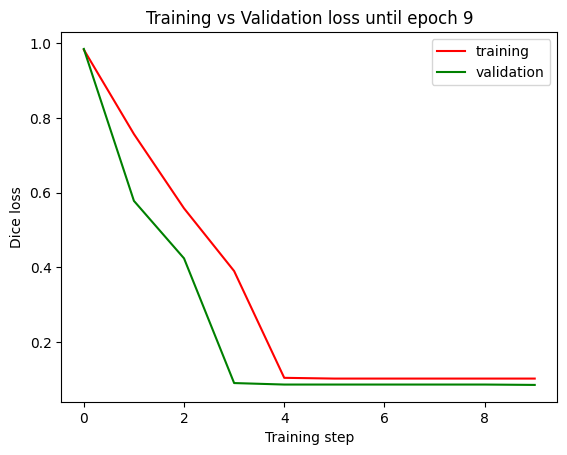


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0937: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0855: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


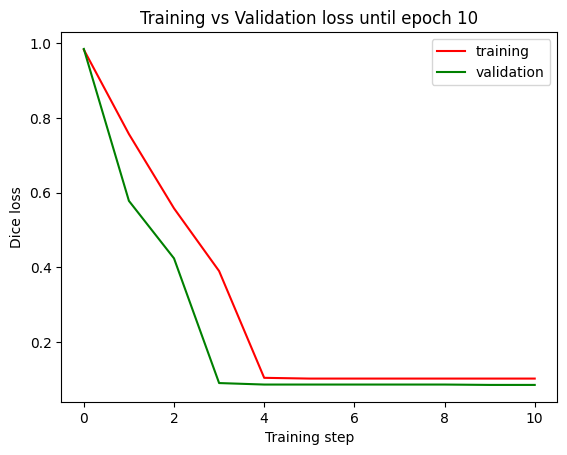


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0935: 100%|████████████████████████████████████████████████████████████| 591/591 [04:35<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.0856: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


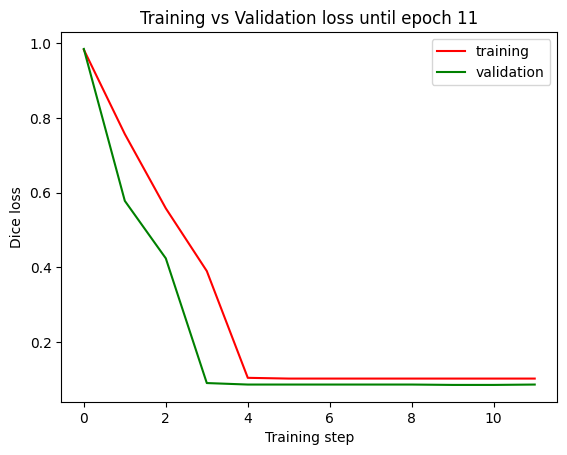

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.10it/s]



 Dice score on test set: 0.9020




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.12it/s]



 Dice score on validation set: 0.9145555284422666



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:36<00:00,  6.10it/s]



 Dice score on train set: 0.8982177993972894


In [9]:
train_and_evaluate_on_task("C")

## Ablation study

### Ablation 1: UNet compression level (2 vs 3 vs 4) 

**Task A -> 4 Level UNET performs best (3 level is almost equal)**

**Task B -> 3 Level and 4 Level UNET performs best (equal)**

**Task C -> All three level UNETs perform equally**

We'll be using 3 level UNET for rest of our ablations (best performance vs size tradeoff)


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.4175: 100%|████████████████████████████████████████████████████████████| 591/591 [03:50<00:00,  2.56it/s]



VALIDATION starts!



validation loss: 0.4306: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.62it/s]


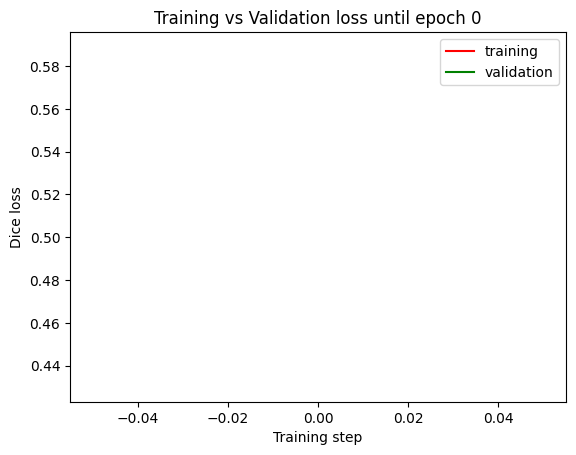


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2748: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.3250: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.64it/s]


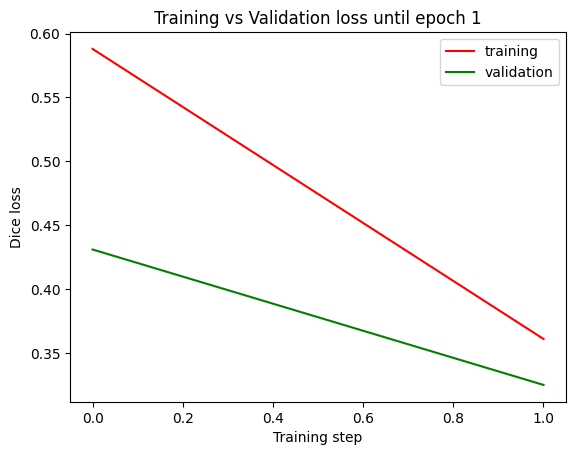


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2172: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.3384: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.63it/s]


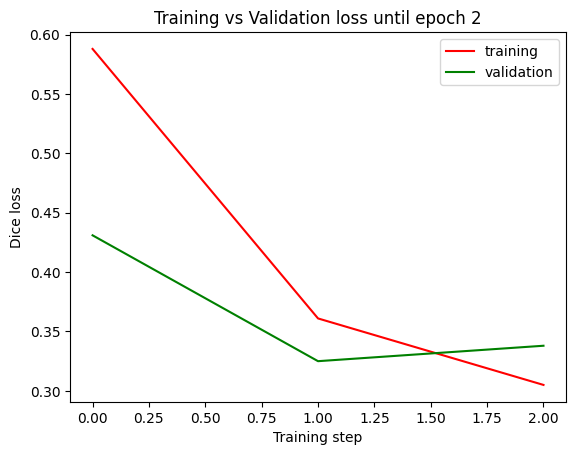


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3827: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.3196: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.93it/s]


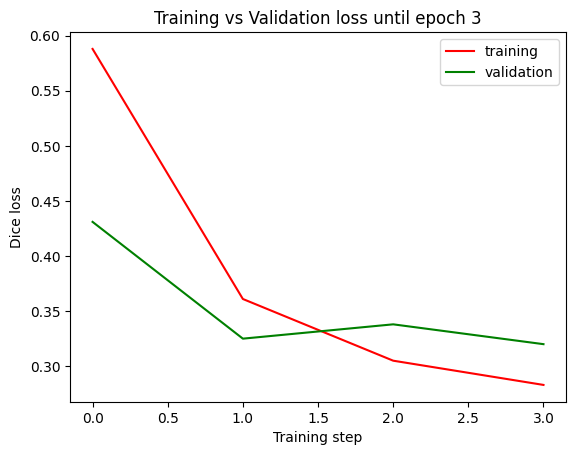


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3471: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.3014: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.63it/s]


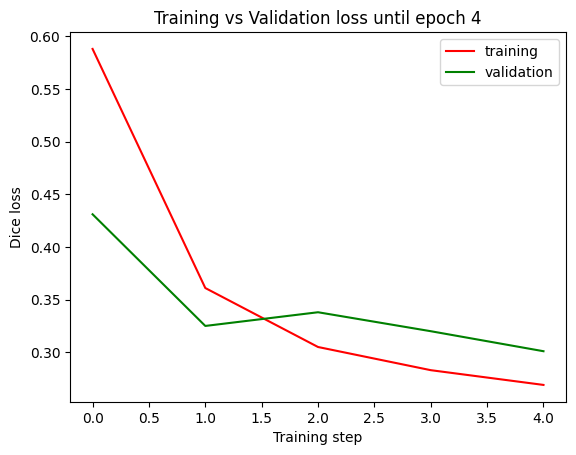


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2343: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.2677: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.90it/s]


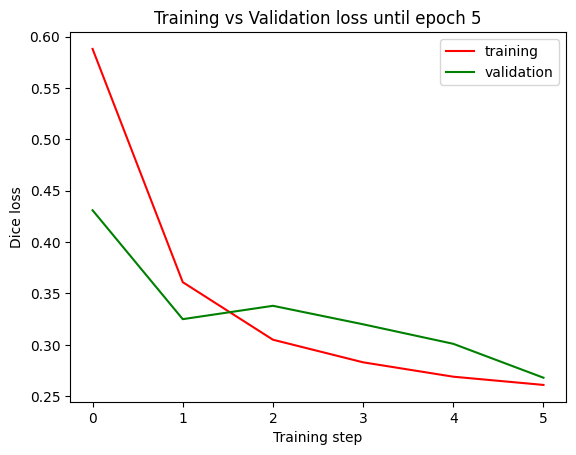


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1810: 100%|████████████████████████████████████████████████████████████| 591/591 [03:49<00:00,  2.58it/s]



VALIDATION starts!



validation loss: 0.2764: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.61it/s]


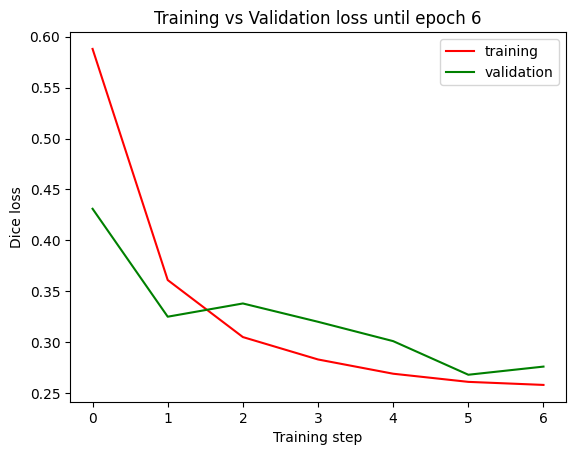


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2057: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.3031: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.97it/s]


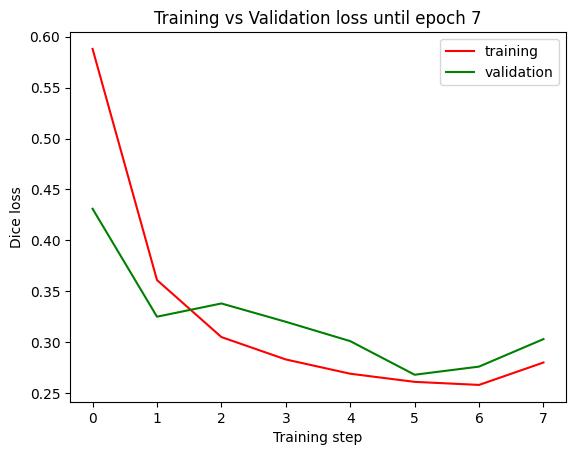


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2547: 100%|████████████████████████████████████████████████████████████| 591/591 [03:44<00:00,  2.63it/s]



VALIDATION starts!



validation loss: 0.3061: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.99it/s]


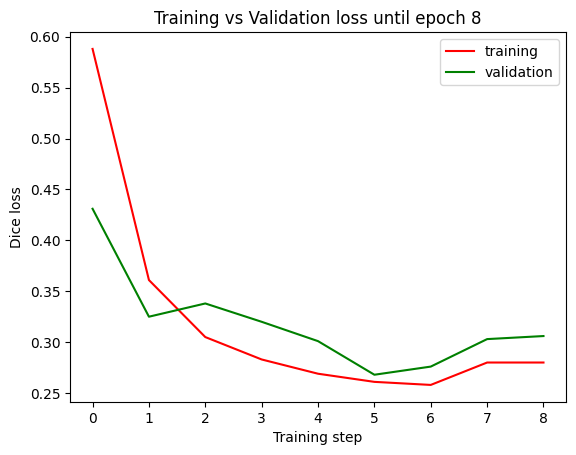


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2847: 100%|████████████████████████████████████████████████████████████| 591/591 [03:43<00:00,  2.64it/s]



VALIDATION starts!



validation loss: 0.3557: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.99it/s]


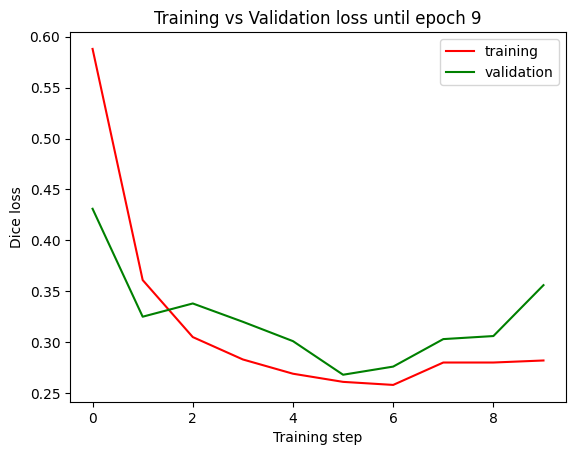


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2471: 100%|████████████████████████████████████████████████████████████| 591/591 [03:43<00:00,  2.64it/s]



VALIDATION starts!



validation loss: 0.2839: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.99it/s]


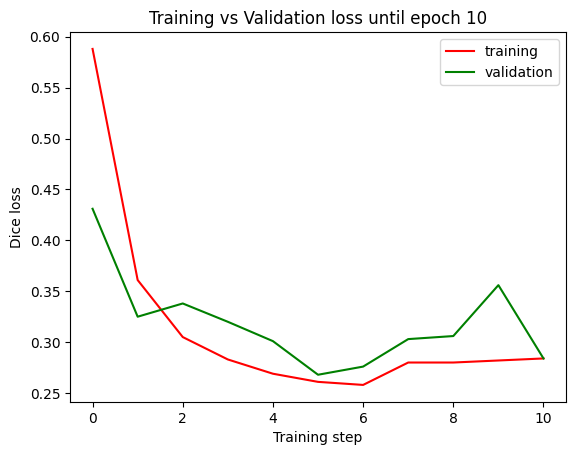


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2358: 100%|████████████████████████████████████████████████████████████| 591/591 [03:48<00:00,  2.59it/s]



VALIDATION starts!



validation loss: 0.2703: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.61it/s]


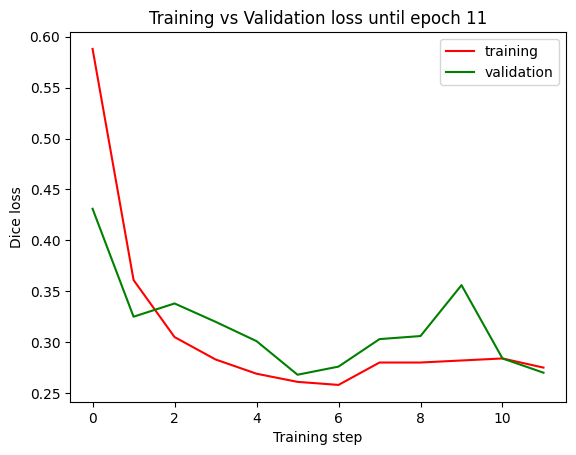

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.67it/s]



 Dice score on test set: 0.7234




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.71it/s]



 Dice score on validation set: 0.7296024415698753



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:16<00:00,  7.77it/s]



 Dice score on train set: 0.7472765599007131


In [7]:
unet_taskA_2levels = train_and_evaluate_on_task(
    "A",
    unet_size=2,
    ablation=True
)

torch.save(unet_taskA_2levels.module.state_dict(), f"ablation_checkpoints/UNET_taskA_2level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2830: 100%|████████████████████████████████████████████████████████████| 591/591 [04:37<00:00,  2.13it/s]



VALIDATION starts!



validation loss: 0.3226: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


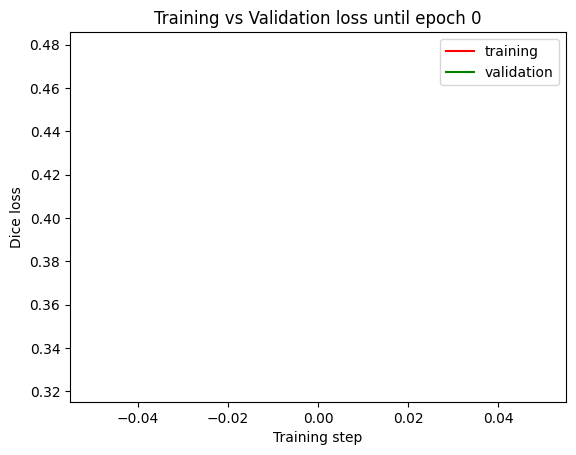


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1691: 100%|████████████████████████████████████████████████████████████| 591/591 [04:37<00:00,  2.13it/s]



VALIDATION starts!



validation loss: 0.2385: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.32it/s]


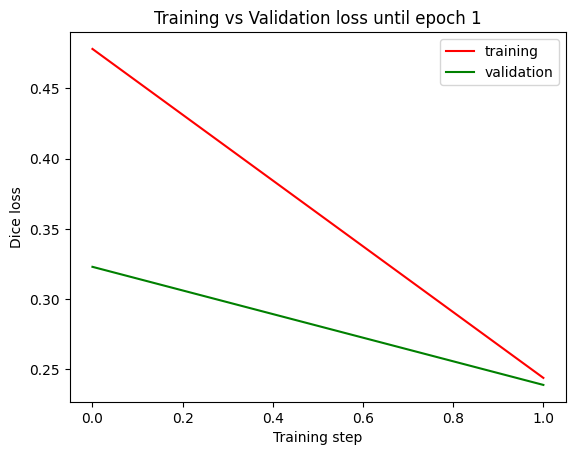


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2833: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.13it/s]



VALIDATION starts!



validation loss: 0.2137: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.30it/s]


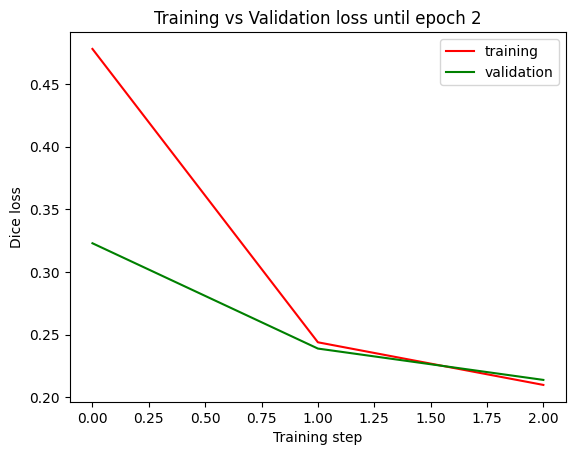


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2454: 100%|████████████████████████████████████████████████████████████| 591/591 [04:29<00:00,  2.19it/s]



VALIDATION starts!



validation loss: 0.1986: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.29it/s]


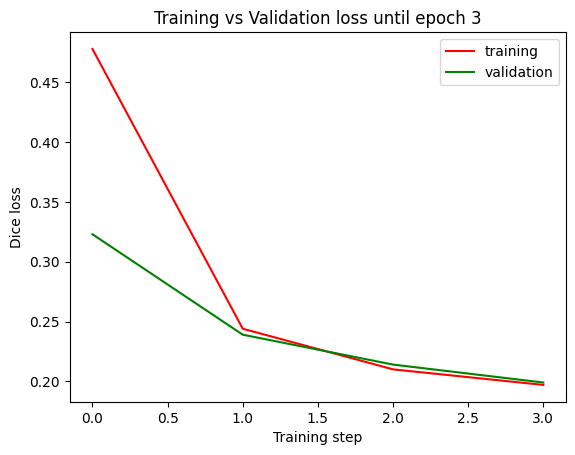


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2697: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2032: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.10it/s]


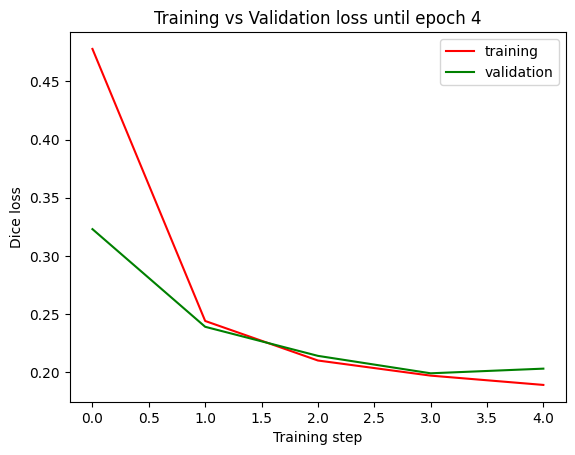


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2665: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1913: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.31it/s]


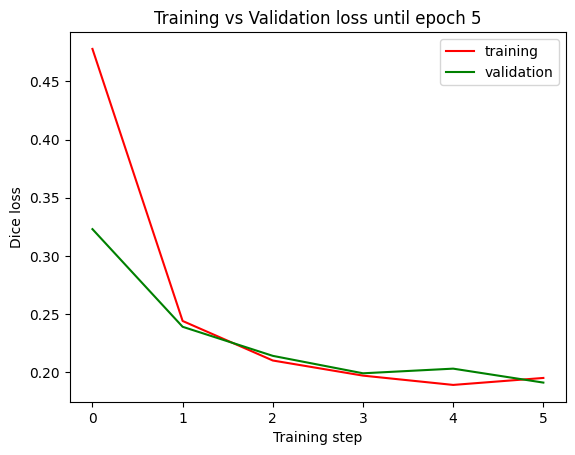


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1518: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2275: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.31it/s]


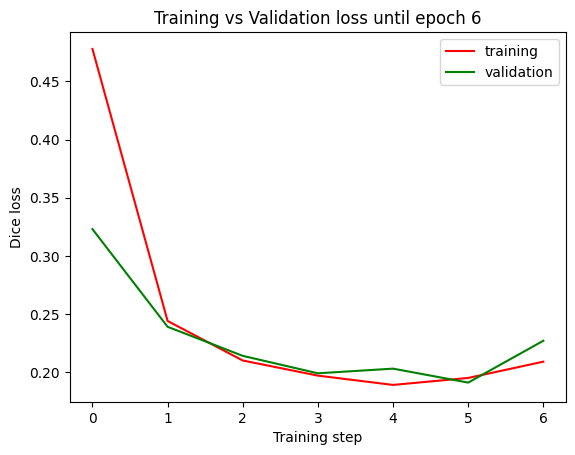


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2621: 100%|████████████████████████████████████████████████████████████| 591/591 [04:28<00:00,  2.20it/s]



VALIDATION starts!



validation loss: 0.2512: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.30it/s]


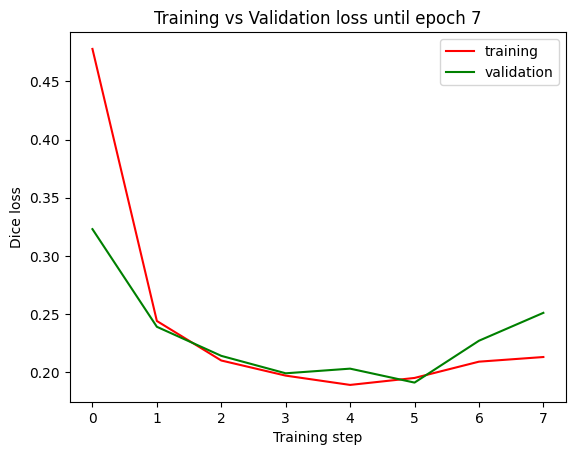


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2041: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.1718: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.31it/s]


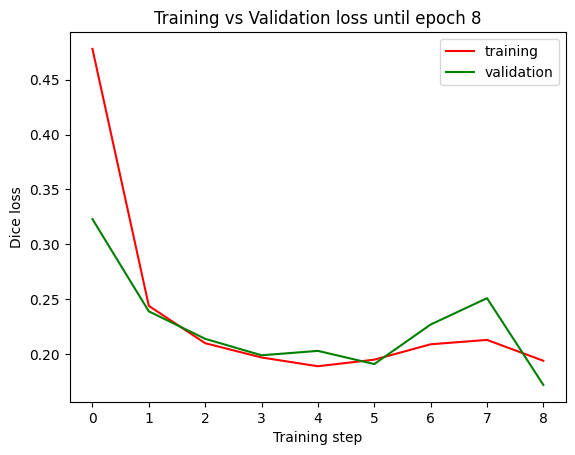


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1389: 100%|████████████████████████████████████████████████████████████| 591/591 [04:28<00:00,  2.20it/s]



VALIDATION starts!



validation loss: 0.1965: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


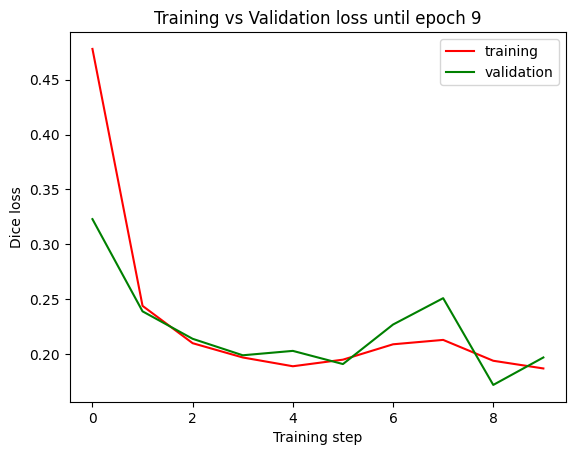


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1902: 100%|████████████████████████████████████████████████████████████| 591/591 [04:36<00:00,  2.14it/s]



VALIDATION starts!



validation loss: 0.2240: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.07it/s]


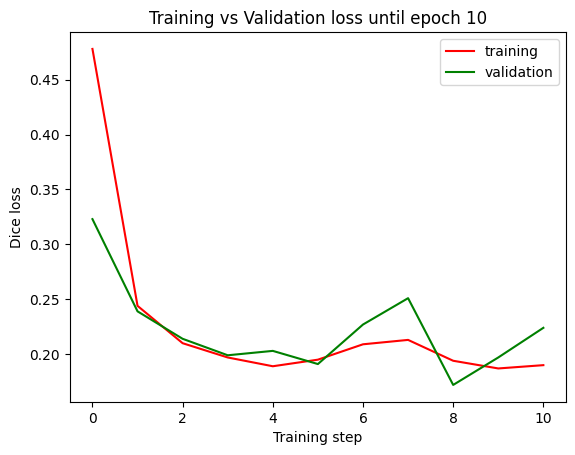


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1597: 100%|████████████████████████████████████████████████████████████| 591/591 [04:29<00:00,  2.19it/s]



VALIDATION starts!



validation loss: 0.2089: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.30it/s]


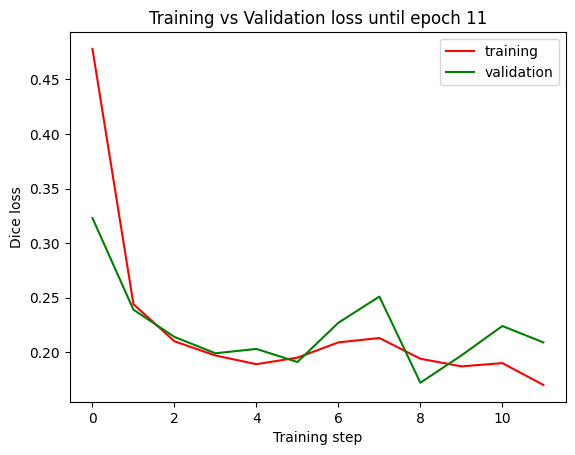

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.16it/s]



 Dice score on test set: 0.7886




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.11it/s]



 Dice score on validation set: 0.79114045921316



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:35<00:00,  6.17it/s]



 Dice score on train set: 0.8020391696197329


In [8]:
unet_taskA_3levels = train_and_evaluate_on_task(
    "A",
    unet_size=3,
    ablation=True
)

torch.save(unet_taskA_3levels.module.state_dict(), f"ablation_checkpoints/UNET_taskA_3level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3394: 100%|████████████████████████████████████████████████████████████| 591/591 [05:39<00:00,  1.74it/s]



VALIDATION starts!



validation loss: 0.3191: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.43it/s]


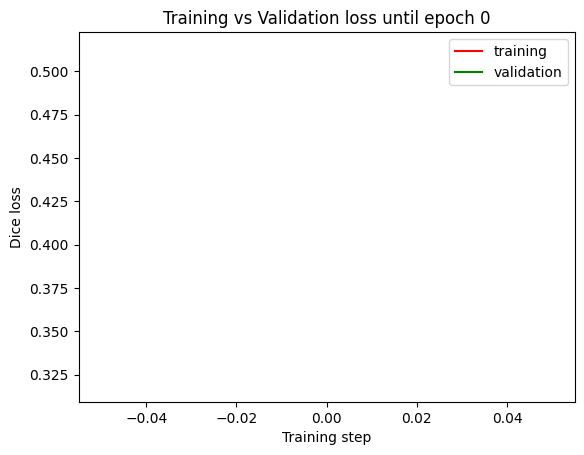


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1947: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.2103: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.45it/s]


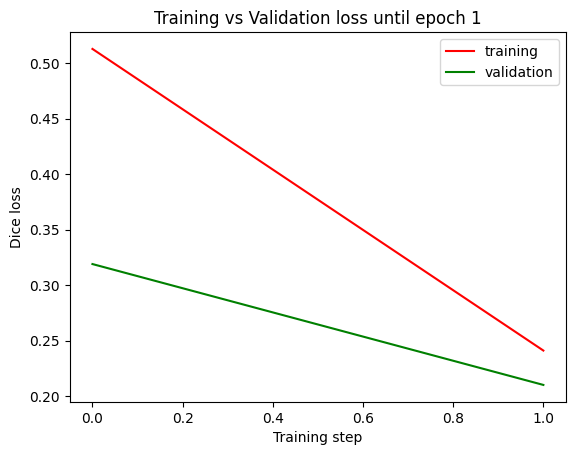


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1926: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.1941: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.44it/s]


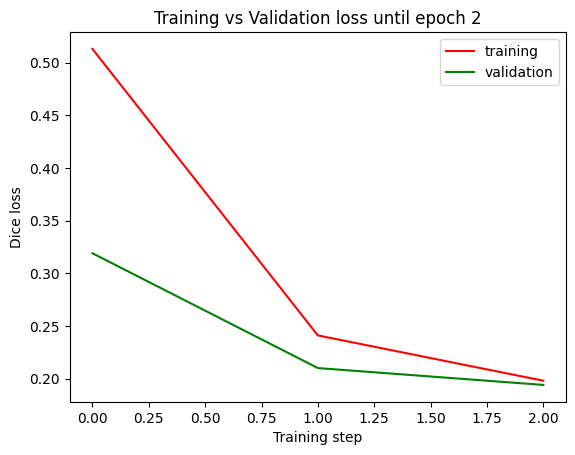


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1831: 100%|████████████████████████████████████████████████████████████| 591/591 [05:37<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.1835: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


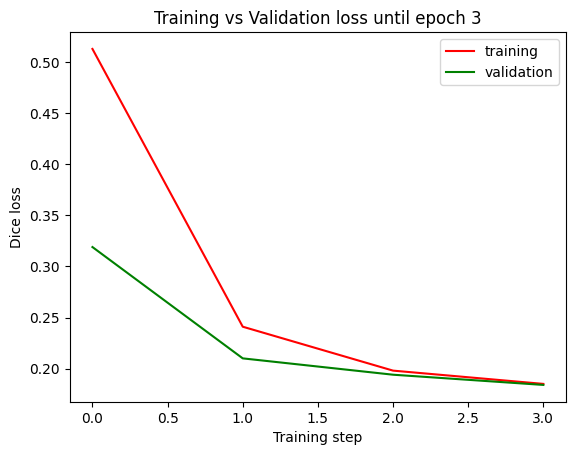


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1029: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.1851: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.45it/s]


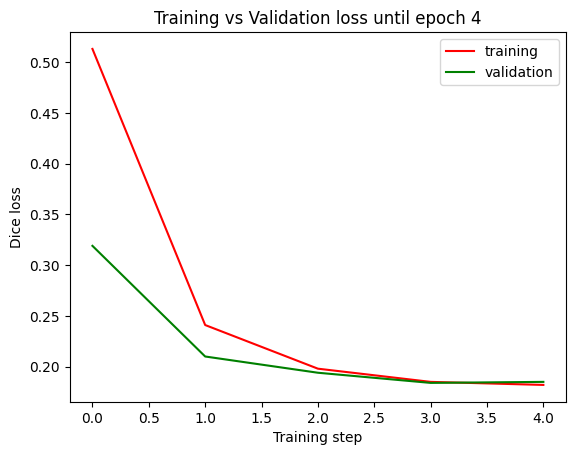


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1939: 100%|████████████████████████████████████████████████████████████| 591/591 [05:37<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.2014: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.43it/s]


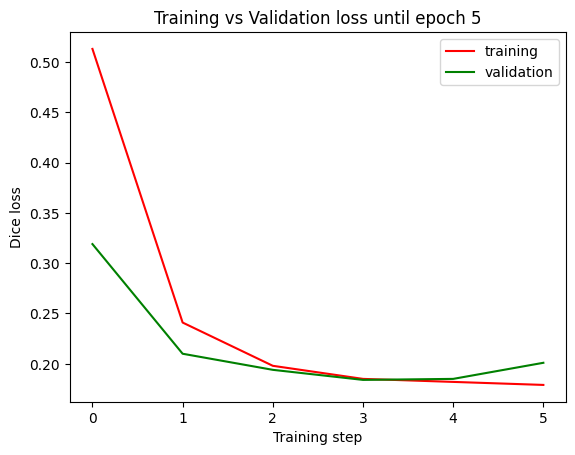


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1810: 100%|████████████████████████████████████████████████████████████| 591/591 [05:37<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.2236: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.44it/s]


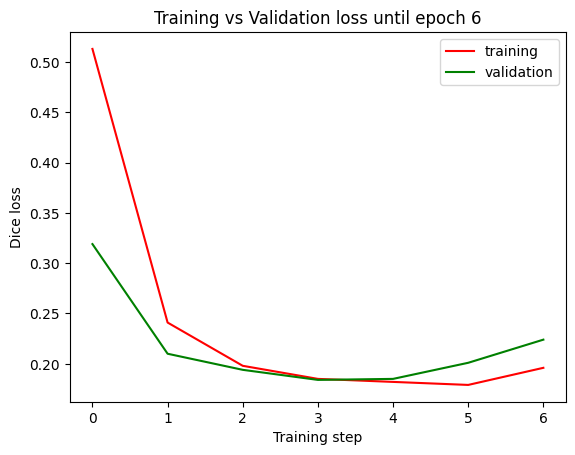


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1775: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.2709: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.43it/s]


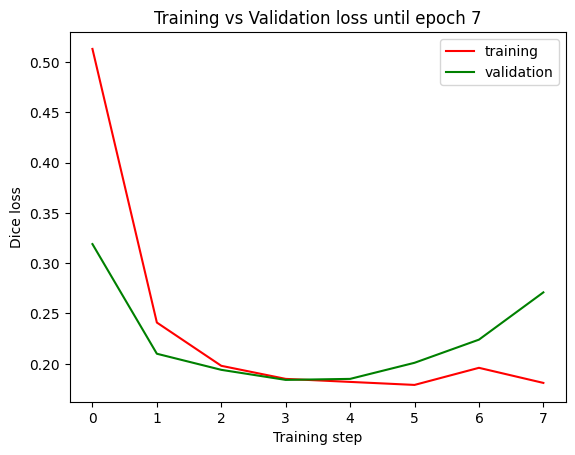


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2036: 100%|████████████████████████████████████████████████████████████| 591/591 [05:37<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.2033: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.42it/s]


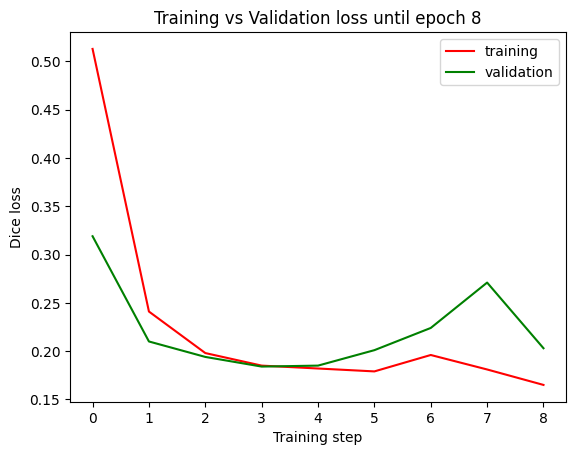


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1417: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.1413: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.42it/s]


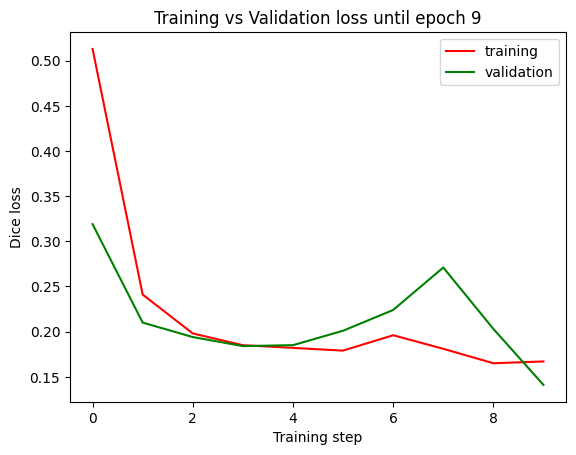


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2304: 100%|████████████████████████████████████████████████████████████| 591/591 [05:37<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.1702: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.43it/s]


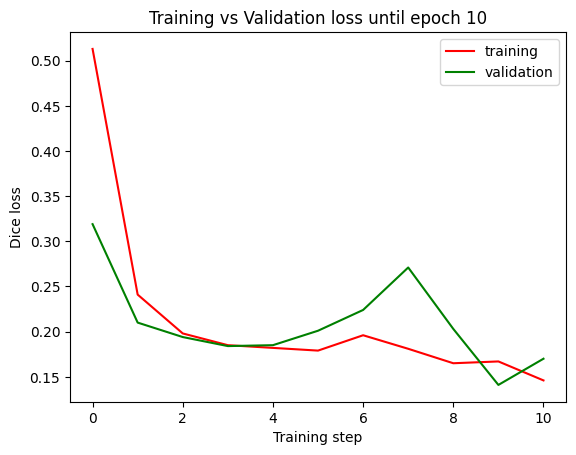


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1685: 100%|████████████████████████████████████████████████████████████| 591/591 [05:37<00:00,  1.75it/s]



VALIDATION starts!



validation loss: 0.1649: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.44it/s]


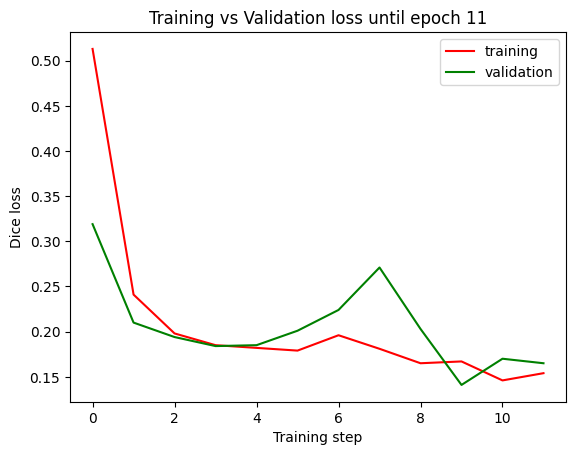

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.46it/s]



 Dice score on test set: 0.8270




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:41<00:00,  4.70it/s]



 Dice score on validation set: 0.8350141084738795



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [02:12<00:00,  4.46it/s]



 Dice score on train set: 0.8387447716620973


In [7]:
unet_taskA_4levels = train_and_evaluate_on_task(
    "A",
    unet_size=4,
    ablation=True
)

torch.save(unet_taskA_4levels.module.state_dict(), f"ablation_checkpoints/UNET_taskA_4level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9997: 100%|████████████████████████████████████████████████████████████| 591/591 [03:43<00:00,  2.64it/s]



VALIDATION starts!



validation loss: 0.9914: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.64it/s]


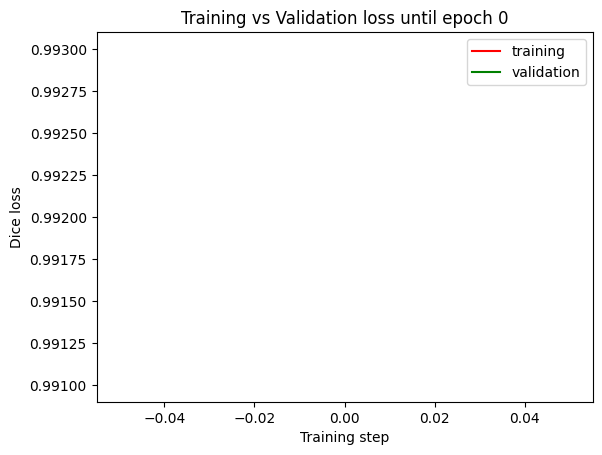


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.7772: 100%|████████████████████████████████████████████████████████████| 591/591 [03:45<00:00,  2.62it/s]



VALIDATION starts!



validation loss: 0.6799: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.89it/s]


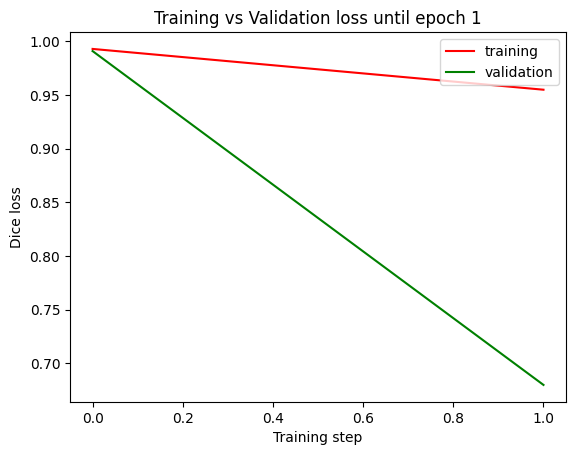


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.4673: 100%|████████████████████████████████████████████████████████████| 591/591 [03:45<00:00,  2.62it/s]



VALIDATION starts!



validation loss: 0.2617: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.65it/s]


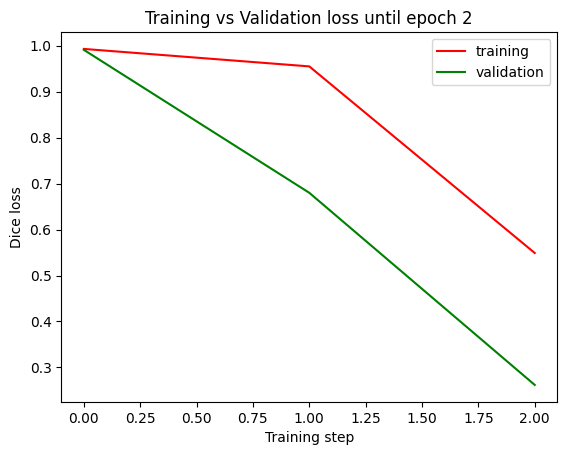


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2298: 100%|████████████████████████████████████████████████████████████| 591/591 [03:45<00:00,  2.62it/s]



VALIDATION starts!



validation loss: 0.2159: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.63it/s]


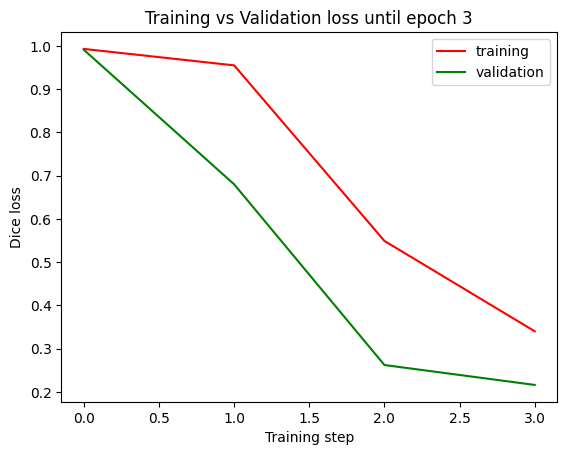


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1872: 100%|████████████████████████████████████████████████████████████| 591/591 [03:40<00:00,  2.68it/s]



VALIDATION starts!



validation loss: 0.0845: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.79it/s]


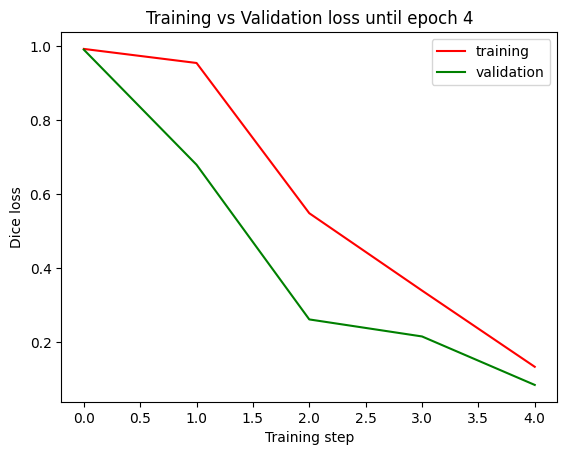


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1566: 100%|████████████████████████████████████████████████████████████| 591/591 [03:41<00:00,  2.67it/s]



VALIDATION starts!



validation loss: 0.0833: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.63it/s]


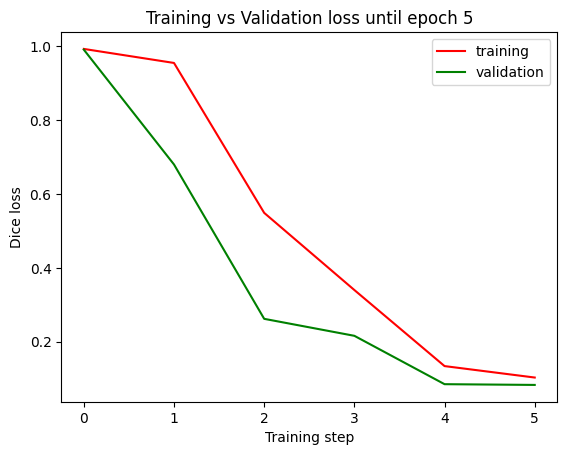


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0314: 100%|████████████████████████████████████████████████████████████| 591/591 [03:41<00:00,  2.67it/s]



VALIDATION starts!



validation loss: 0.0832: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.67it/s]


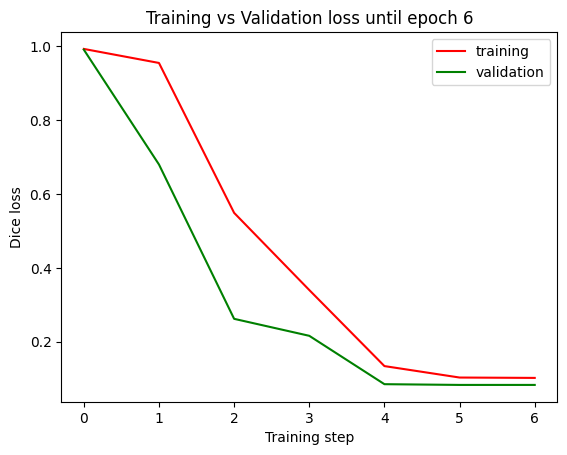


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0932: 100%|████████████████████████████████████████████████████████████| 591/591 [03:40<00:00,  2.68it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.65it/s]


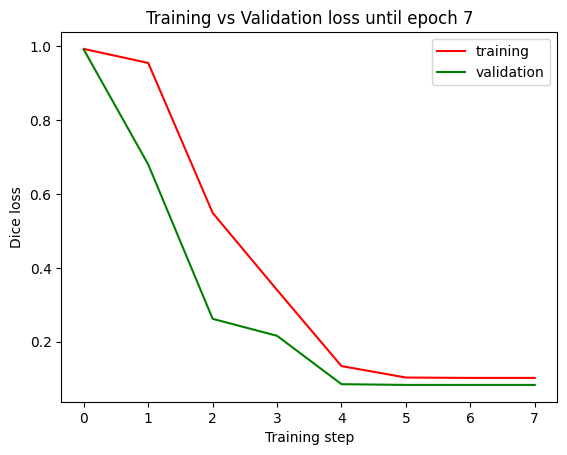


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1249: 100%|████████████████████████████████████████████████████████████| 591/591 [03:40<00:00,  2.68it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.64it/s]


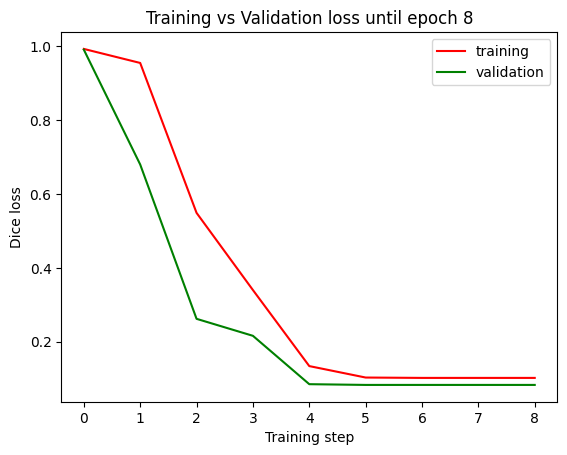


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2173: 100%|████████████████████████████████████████████████████████████| 591/591 [03:40<00:00,  2.67it/s]



VALIDATION starts!



validation loss: 0.0830: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.85it/s]


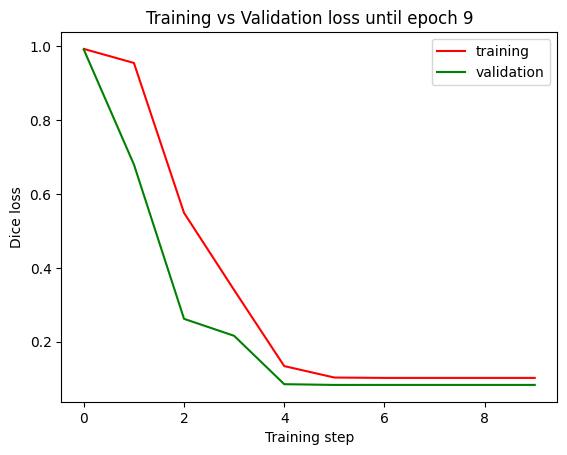


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0936: 100%|████████████████████████████████████████████████████████████| 591/591 [03:40<00:00,  2.68it/s]



VALIDATION starts!



validation loss: 0.0830: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.61it/s]


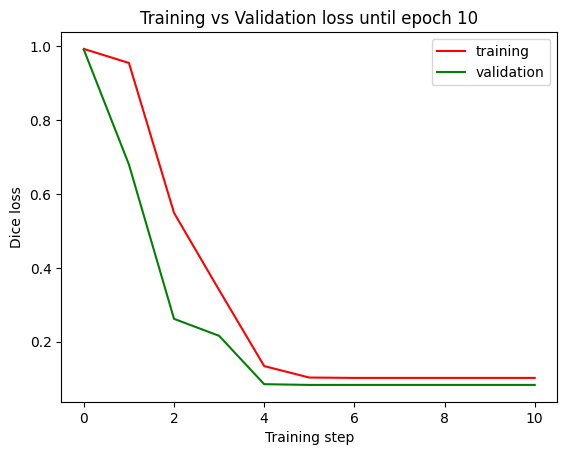


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0624: 100%|████████████████████████████████████████████████████████████| 591/591 [03:40<00:00,  2.68it/s]



VALIDATION starts!



validation loss: 0.0829: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.61it/s]


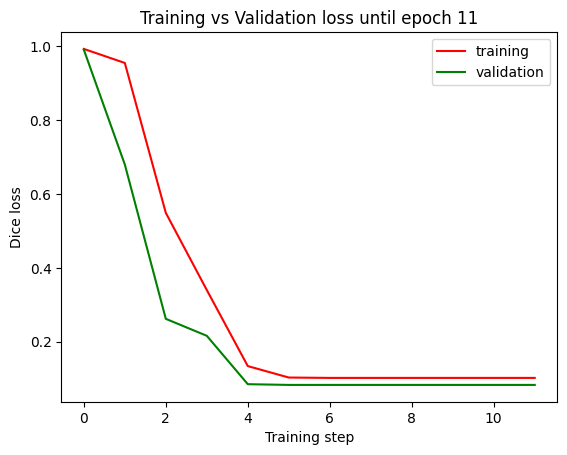

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.65it/s]



 Dice score on test set: 0.8984




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.68it/s]



 Dice score on validation set: 0.9169833427153263



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:16<00:00,  7.68it/s]



 Dice score on train set: 0.8983790723200377


In [8]:
unet_taskB_2levels = train_and_evaluate_on_task(
    "B",
    unet_size=2,
    ablation=True
)

torch.save(unet_taskB_2levels.module.state_dict(), f"ablation_checkpoints/UNET_taskB_2level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9983: 100%|████████████████████████████████████████████████████████████| 591/591 [04:31<00:00,  2.17it/s]



VALIDATION starts!



validation loss: 0.9989: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.19it/s]


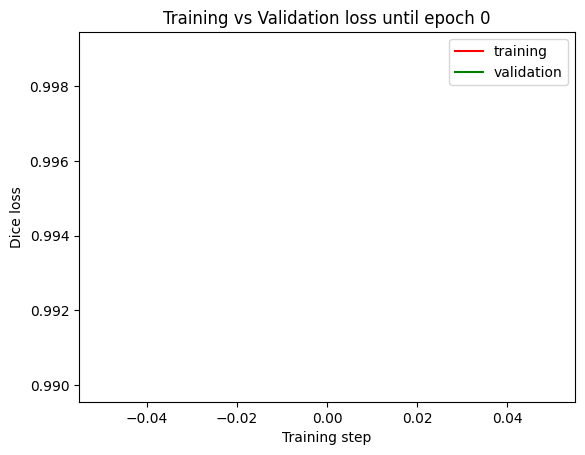


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6044: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.6838: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.18it/s]


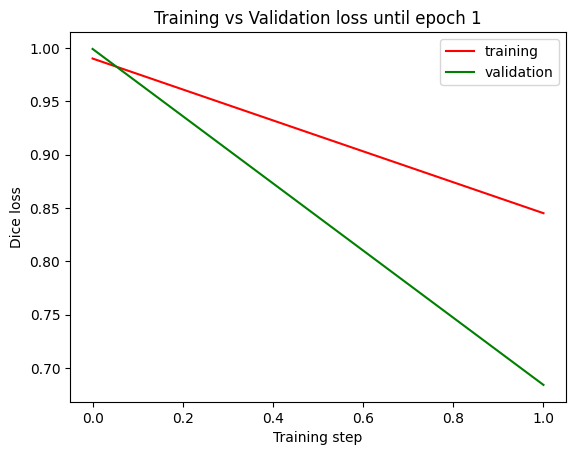


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.4824: 100%|████████████████████████████████████████████████████████████| 591/591 [04:25<00:00,  2.22it/s]



VALIDATION starts!



validation loss: 0.1284: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.18it/s]


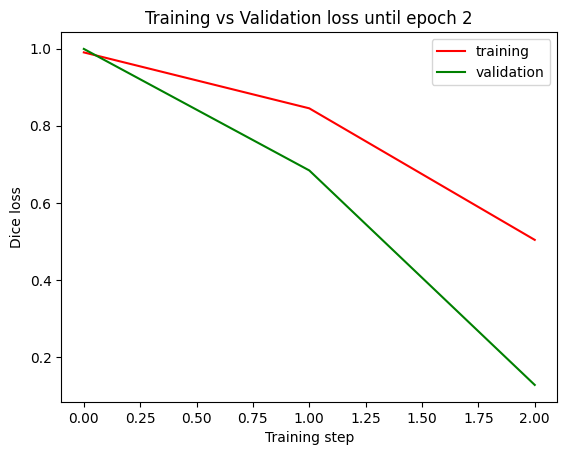


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2431: 100%|████████████████████████████████████████████████████████████| 591/591 [04:25<00:00,  2.22it/s]



VALIDATION starts!



validation loss: 0.2106: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.23it/s]


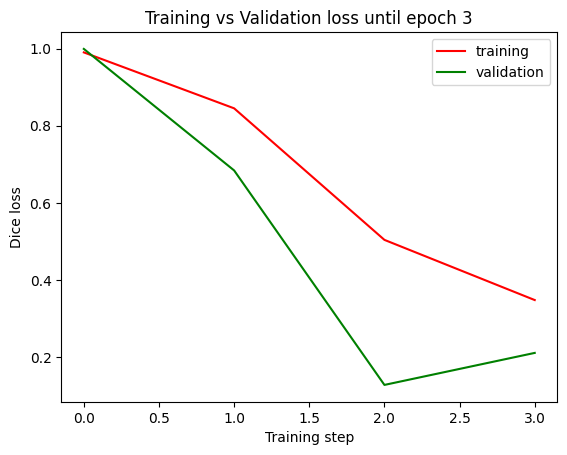


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2202: 100%|████████████████████████████████████████████████████████████| 591/591 [04:25<00:00,  2.22it/s]



VALIDATION starts!



validation loss: 0.1857: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.18it/s]


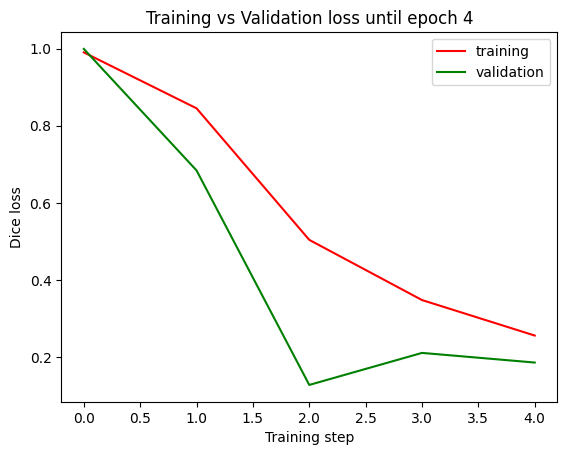


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1618: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.1850: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.20it/s]


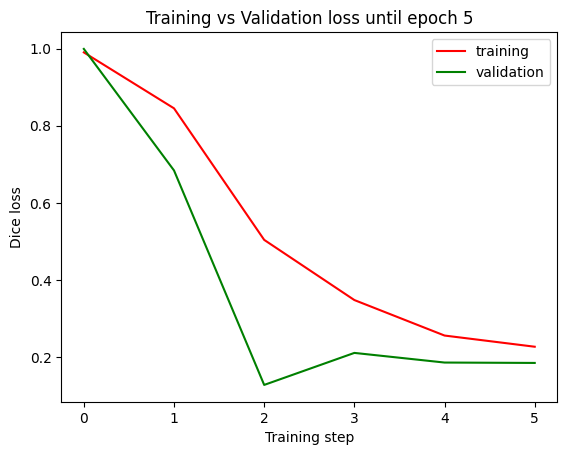


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1258: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0840: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.19it/s]


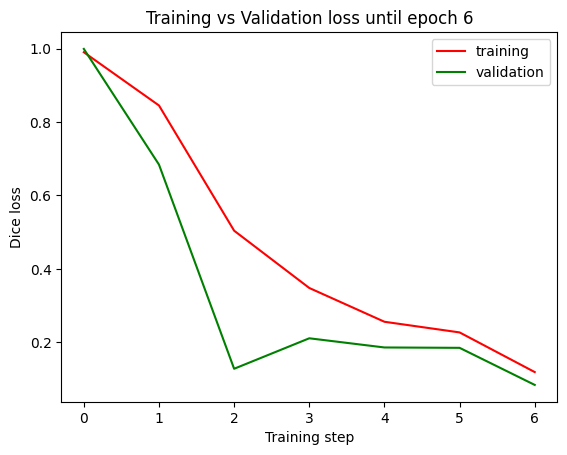


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0316: 100%|████████████████████████████████████████████████████████████| 591/591 [04:26<00:00,  2.22it/s]



VALIDATION starts!



validation loss: 0.0833: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.22it/s]


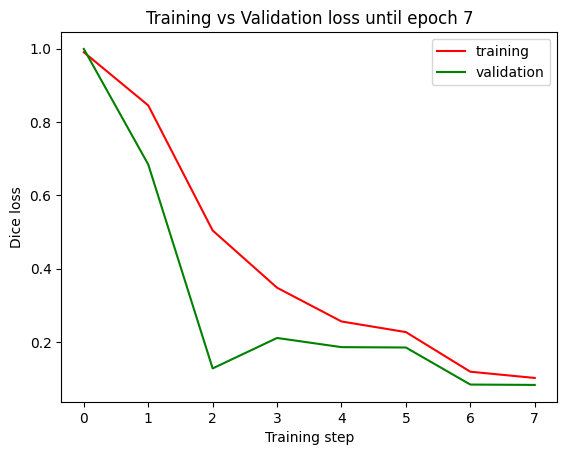


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1558: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0834: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.17it/s]


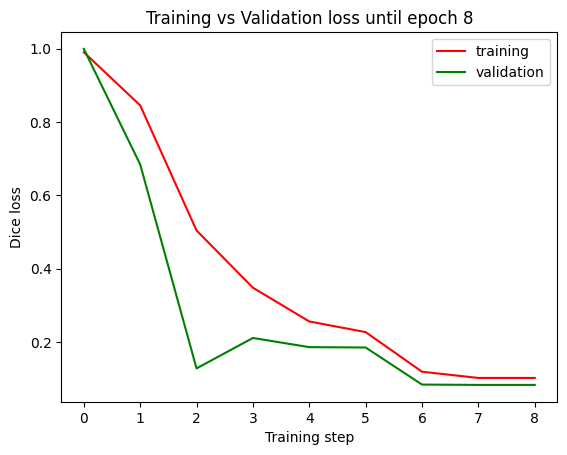


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0612: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.17it/s]


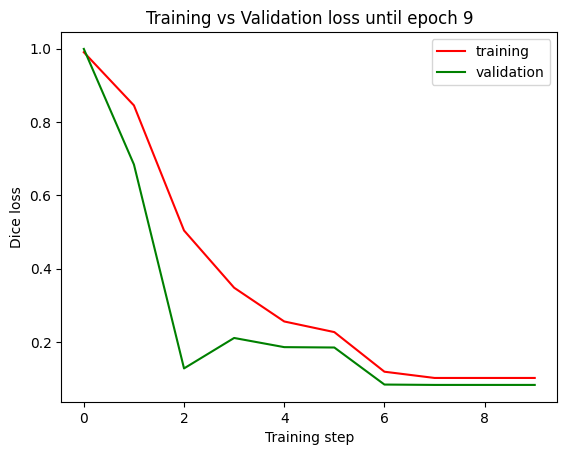


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1528: 100%|████████████████████████████████████████████████████████████| 591/591 [04:26<00:00,  2.22it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.17it/s]


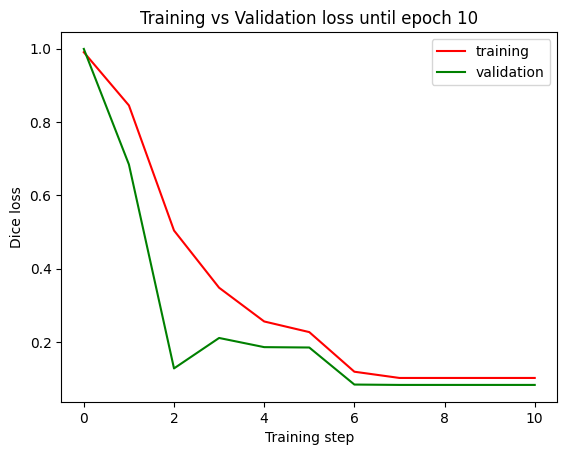


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0622: 100%|████████████████████████████████████████████████████████████| 591/591 [04:34<00:00,  2.15it/s]



VALIDATION starts!



validation loss: 0.0829: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.16it/s]


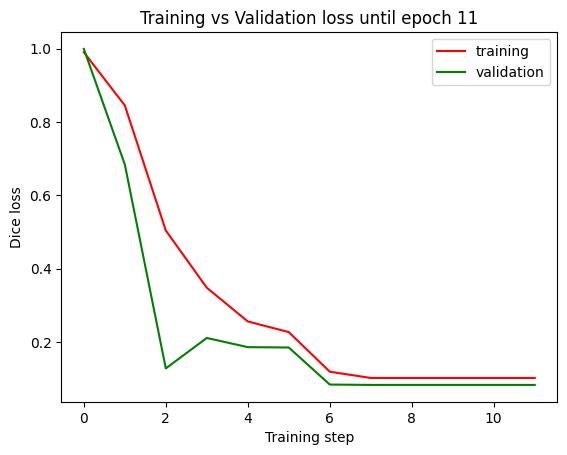

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.26it/s]



 Dice score on test set: 0.8985




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:31<00:00,  6.20it/s]



 Dice score on validation set: 0.9170238532995815



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:34<00:00,  6.23it/s]



 Dice score on train set: 0.8983747511345723


In [17]:
unet_taskB_3levels = train_and_evaluate_on_task(
    "B",
    unet_size=3,
    ablation=True
)

torch.save(unet_taskB_3levels.module.state_dict(), f"ablation_checkpoints/UNET_taskB_3level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9732: 100%|████████████████████████████████████████████████████████████| 591/591 [05:33<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.9911: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.42it/s]


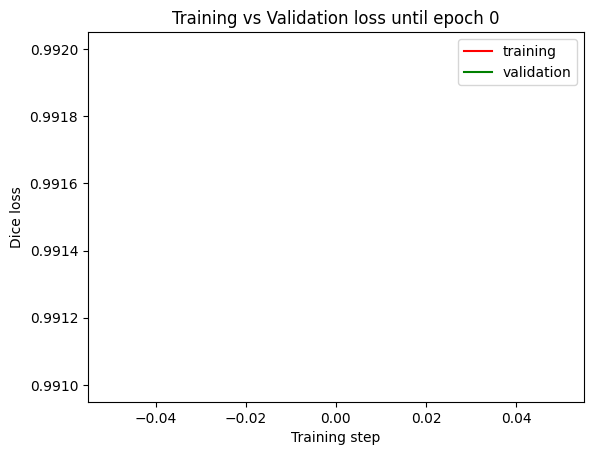


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5123: 100%|████████████████████████████████████████████████████████████| 591/591 [05:34<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.5054: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


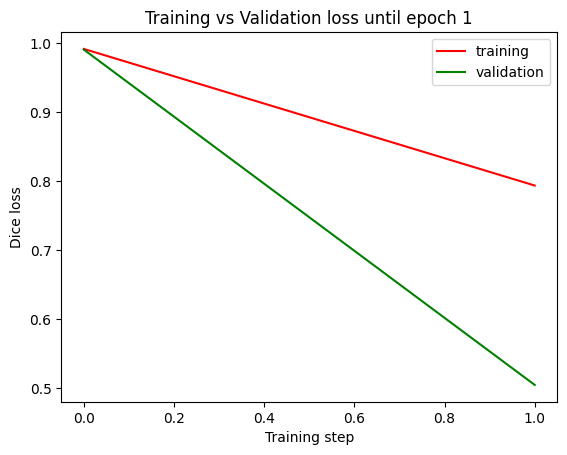


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.4185: 100%|████████████████████████████████████████████████████████████| 591/591 [05:33<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.1677: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.42it/s]


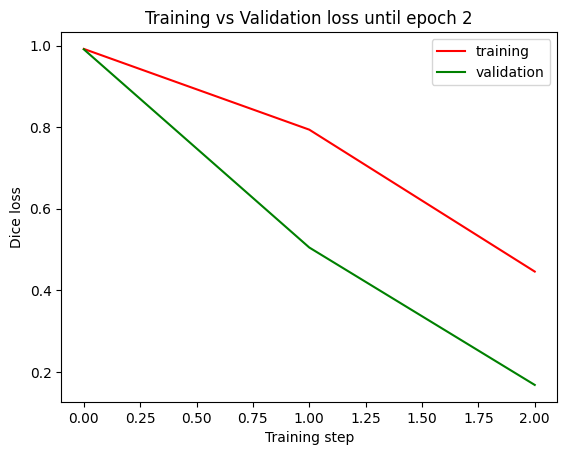


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3765: 100%|████████████████████████████████████████████████████████████| 591/591 [05:34<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.1970: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


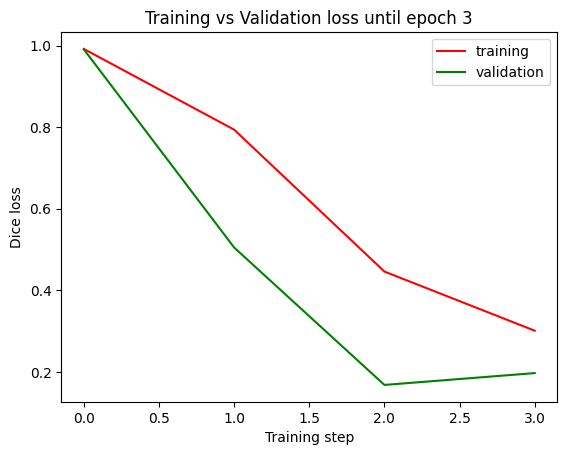


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1727: 100%|████████████████████████████████████████████████████████████| 591/591 [05:35<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.2609: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


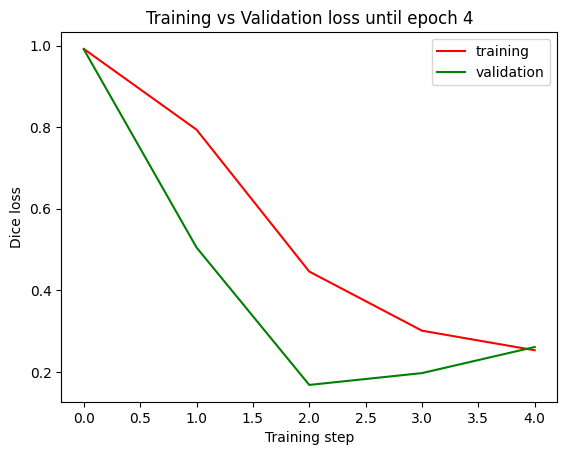


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2824: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.1675: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


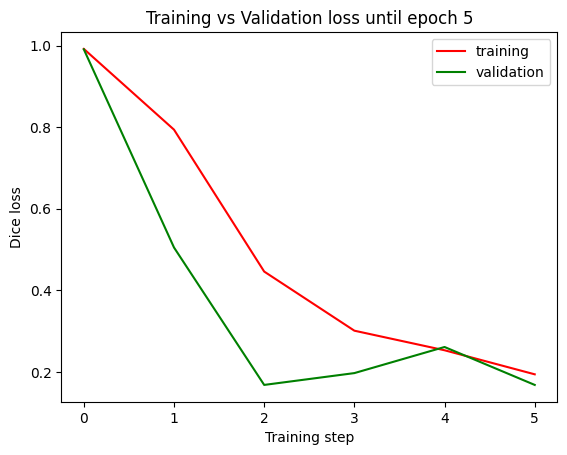


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0930: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.0833: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


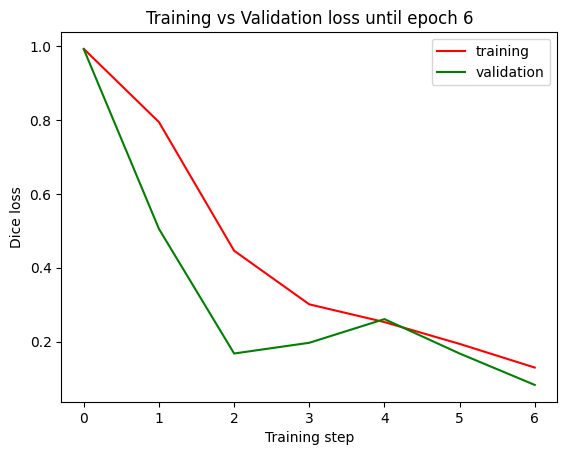


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0626: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.0832: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.40it/s]


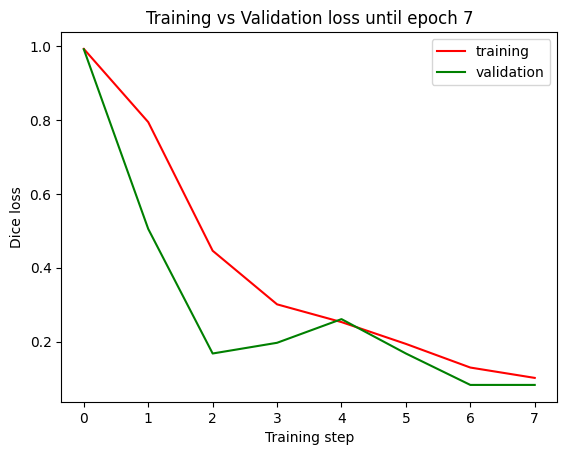


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2472: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.41it/s]


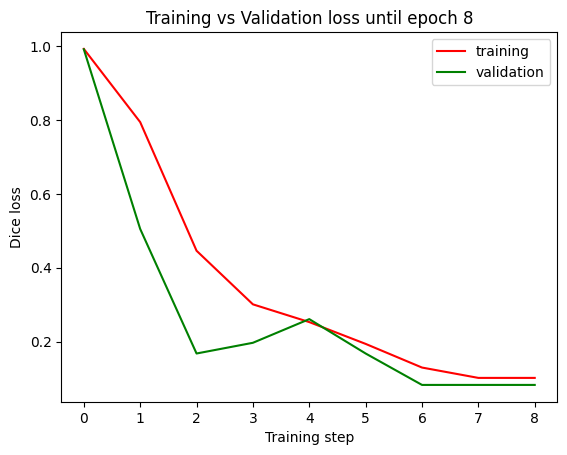


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2185: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.0830: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.40it/s]


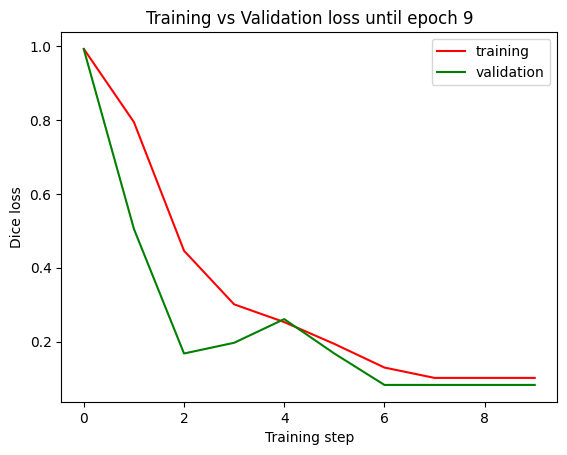


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1248: 100%|████████████████████████████████████████████████████████████| 591/591 [05:36<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.0831: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.40it/s]


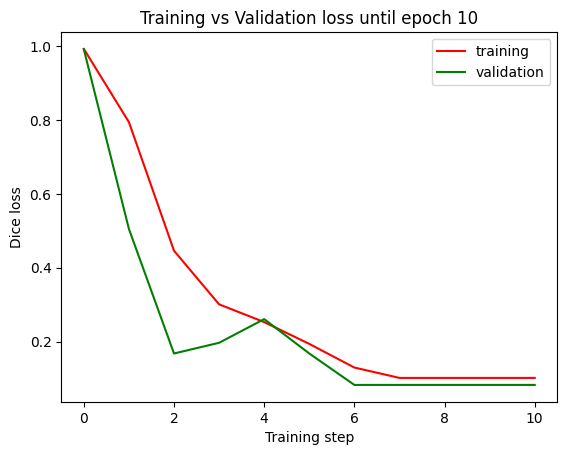


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1246: 100%|████████████████████████████████████████████████████████████| 591/591 [05:35<00:00,  1.76it/s]



VALIDATION starts!



validation loss: 0.0829: 100%|██████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.40it/s]


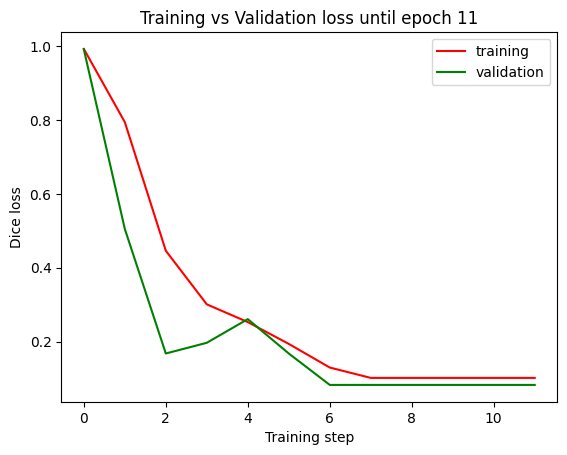

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.43it/s]



 Dice score on test set: 0.8985




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:44<00:00,  4.45it/s]



 Dice score on validation set: 0.9169703722000122



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [02:12<00:00,  4.45it/s]



 Dice score on train set: 0.8983720587393152


In [18]:
unet_taskB_4levels = train_and_evaluate_on_task(
    "B",
    unet_size=4,
    ablation=True
)

torch.save(unet_taskB_4levels.module.state_dict(), f"ablation_checkpoints/UNET_taskB_4level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9925: 100%|████████████████████████████████████████████████████████████| 591/591 [03:36<00:00,  2.73it/s]



VALIDATION starts!



validation loss: 0.9839: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.76it/s]


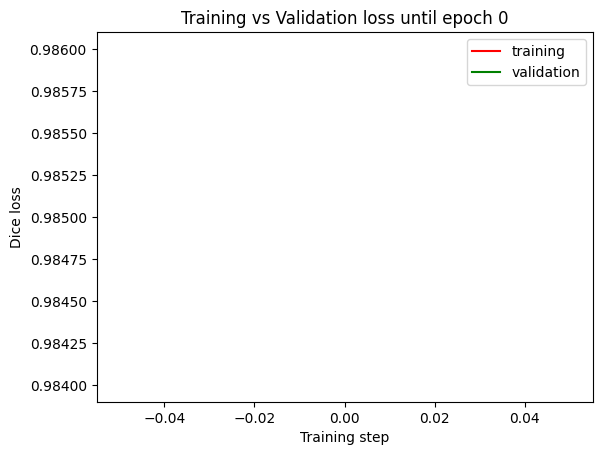


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.7228: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.5661: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.89it/s]


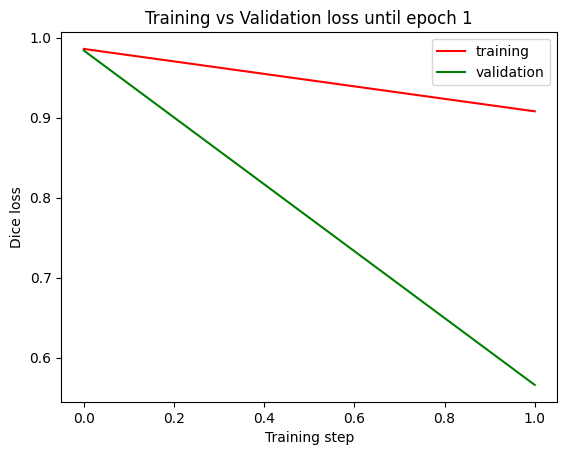


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0368: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0903: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.90it/s]


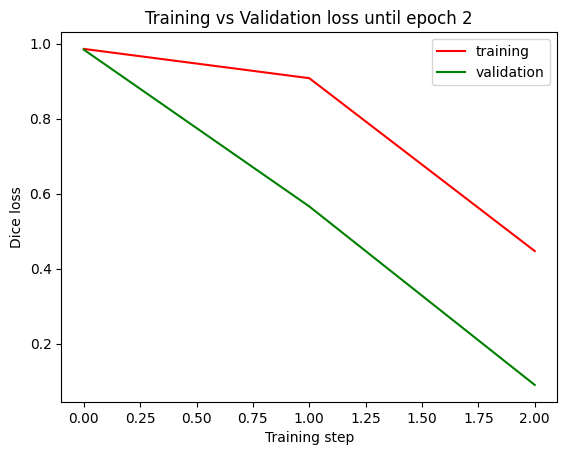


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1257: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0864: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.90it/s]


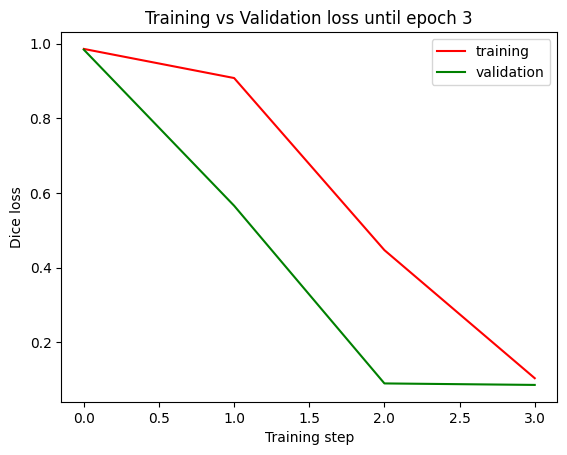


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0318: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0859: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.93it/s]


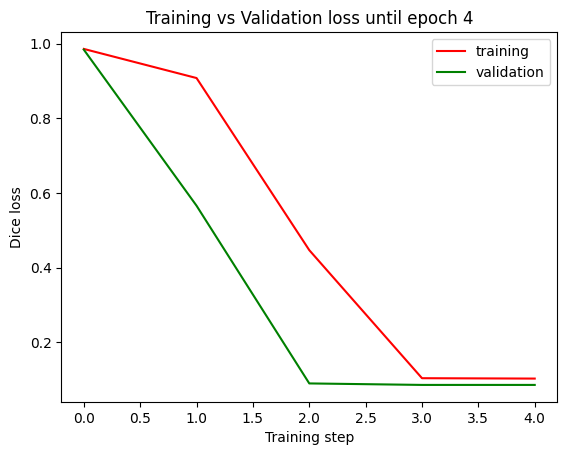


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1246: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0857: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.89it/s]


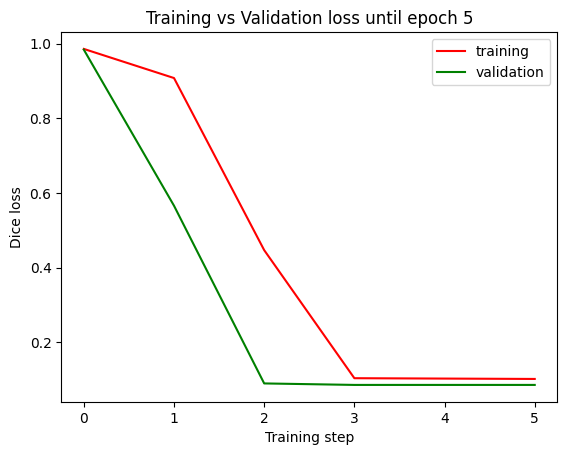


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1250: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0854: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.90it/s]


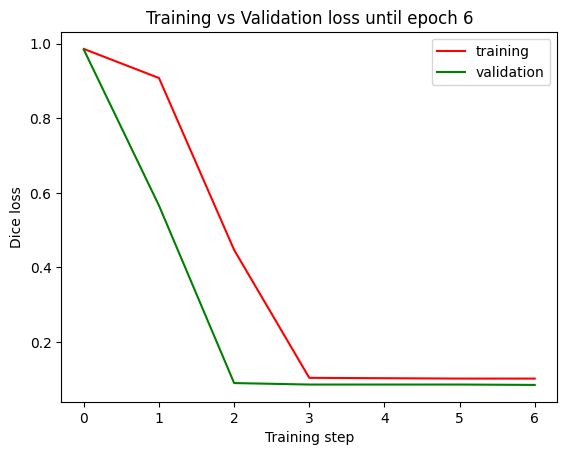


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0625: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0853: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.72it/s]


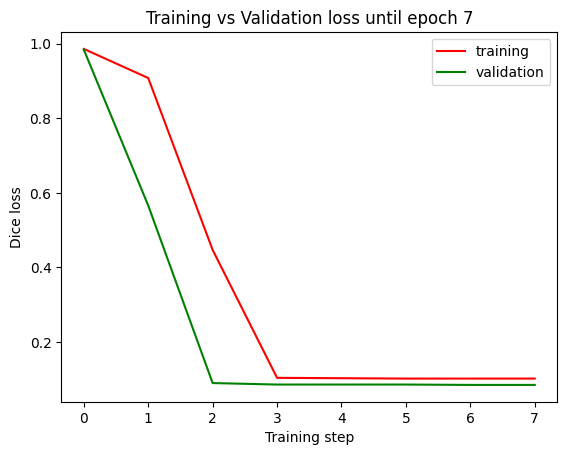


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1248: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0854: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.77it/s]


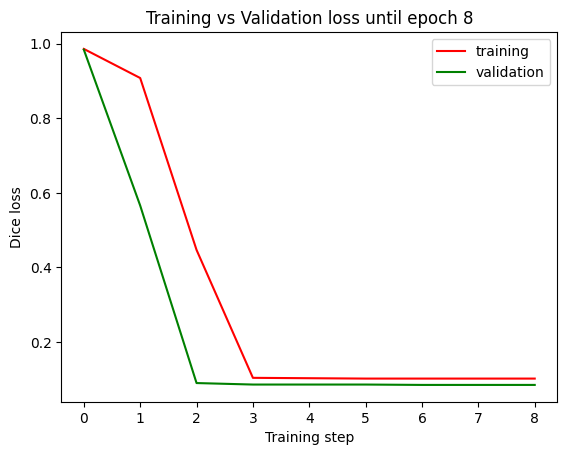


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0616: 100%|████████████████████████████████████████████████████████████| 591/591 [03:37<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0854: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.76it/s]


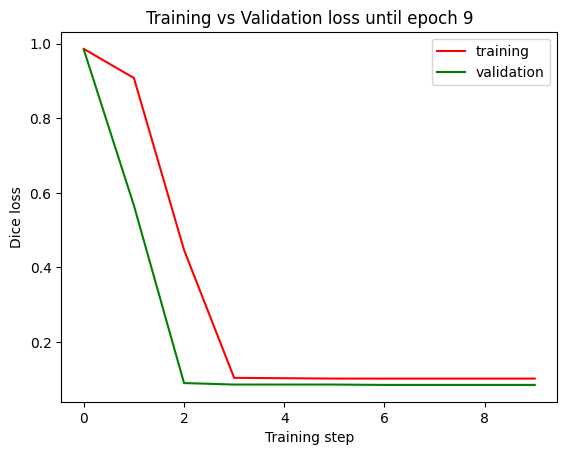


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0934: 100%|████████████████████████████████████████████████████████████| 591/591 [03:36<00:00,  2.73it/s]



VALIDATION starts!



validation loss: 0.0854: 100%|██████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.93it/s]


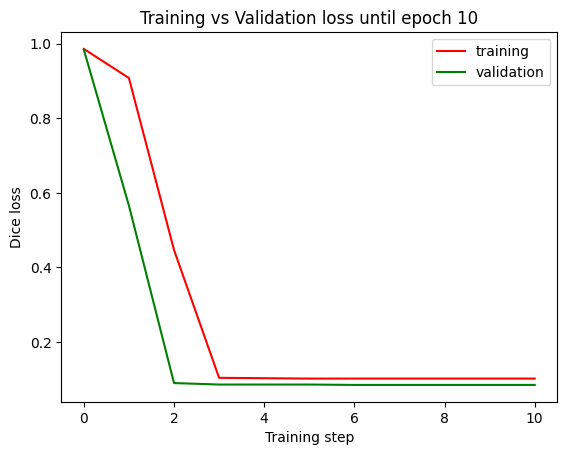


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1241: 100%|████████████████████████████████████████████████████████████| 591/591 [03:36<00:00,  2.72it/s]



VALIDATION starts!



validation loss: 0.0853: 100%|██████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.88it/s]


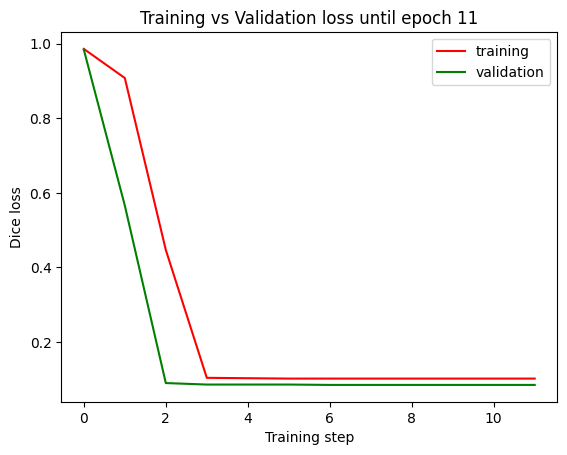

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:25<00:00,  7.85it/s]



 Dice score on test set: 0.9020




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:24<00:00,  7.96it/s]



 Dice score on validation set: 0.9144983878595575



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:14<00:00,  7.88it/s]



 Dice score on train set: 0.8982034114815055


In [19]:
unet_taskC_2levels = train_and_evaluate_on_task(
    "C",
    unet_size=2,
    ablation=True
)

torch.save(unet_taskC_2levels.module.state_dict(), f"ablation_checkpoints/UNET_taskC_2level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9818: 100%|████████████████████████████████████████████████████████████| 591/591 [04:30<00:00,  2.18it/s]



VALIDATION starts!



validation loss: 0.9821: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


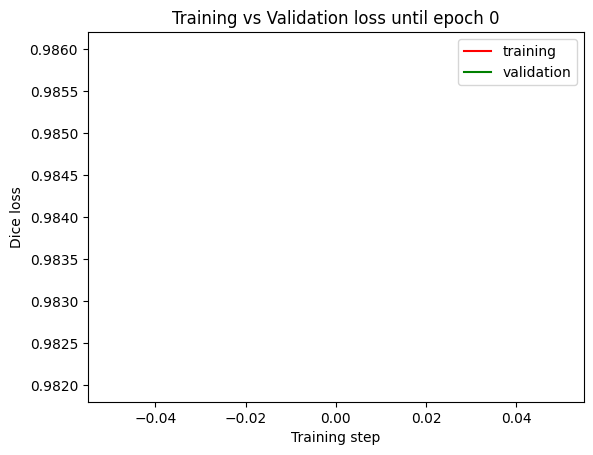


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9805: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.9791: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]


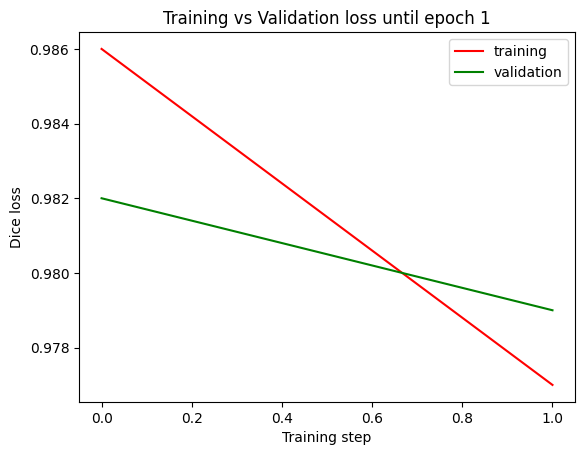


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1693: 100%|████████████████████████████████████████████████████████████| 591/591 [04:32<00:00,  2.17it/s]



VALIDATION starts!



validation loss: 0.1263: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


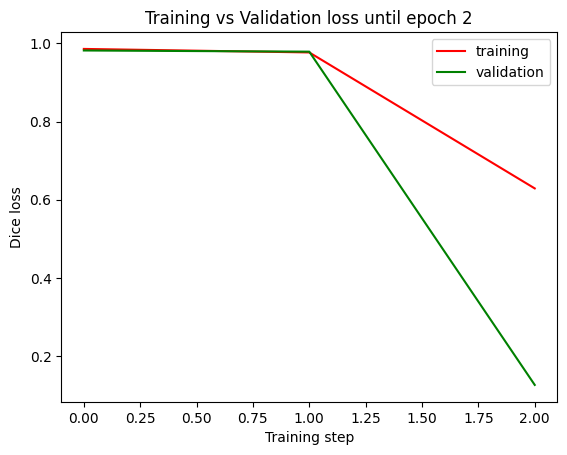


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1280: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0888: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.04it/s]


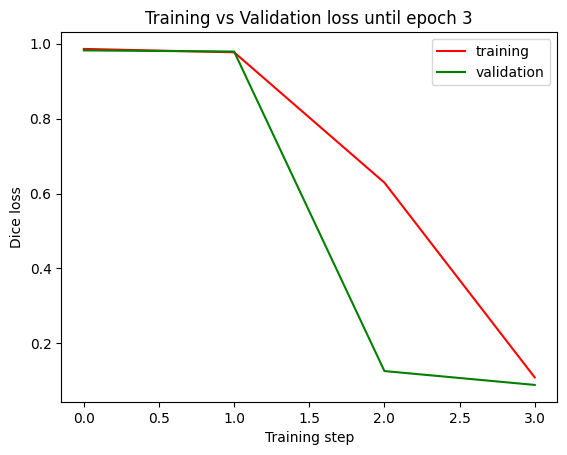


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1257: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0869: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.03it/s]


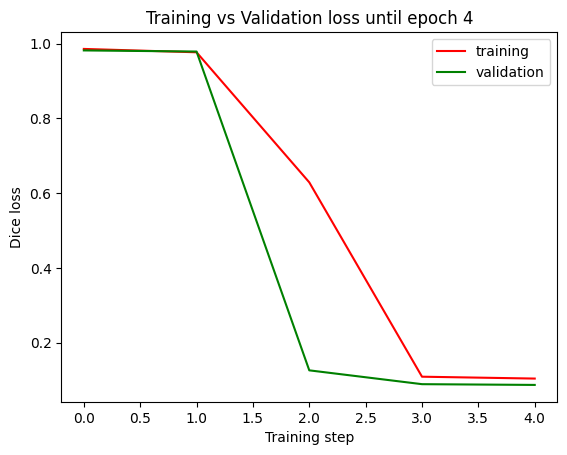


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0634: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0870: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.06it/s]


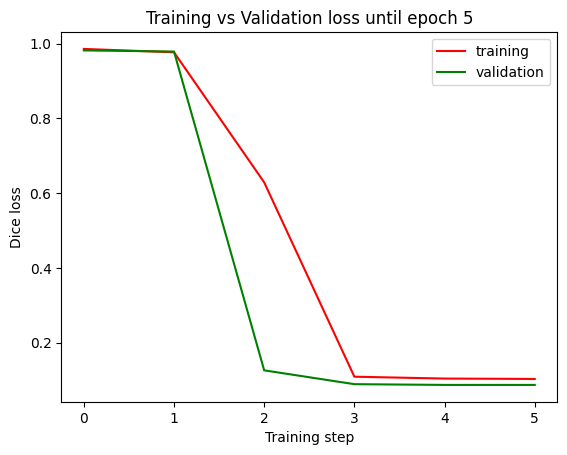


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0942: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0862: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


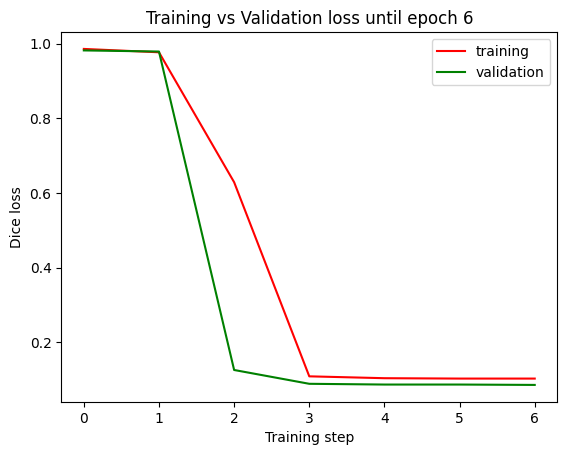


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0937: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0856: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


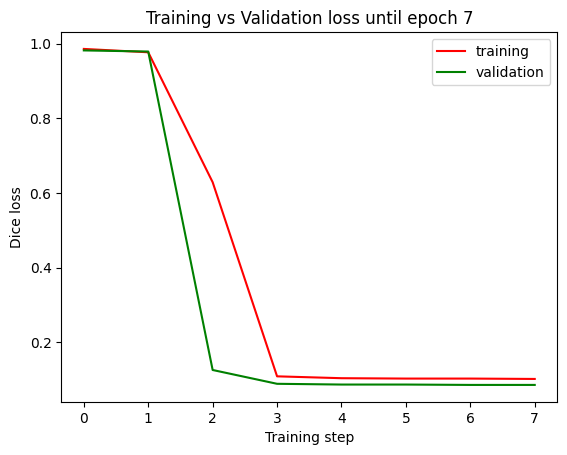


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0938: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0856: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


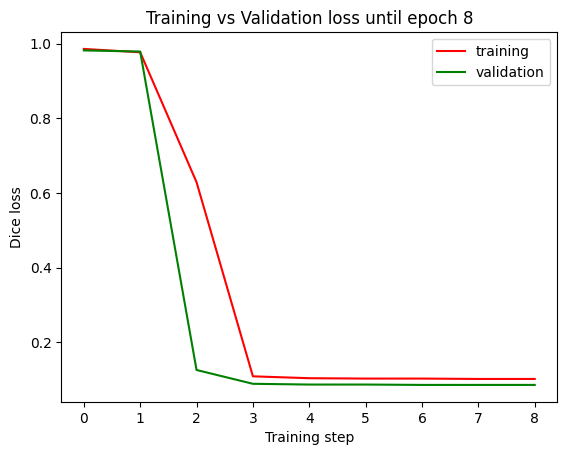


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0624: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0855: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.06it/s]


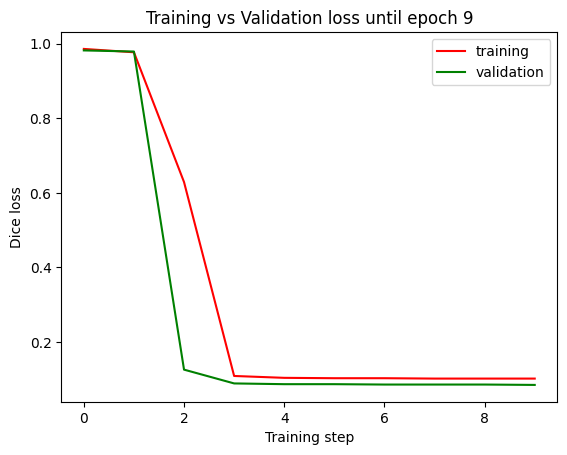


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0934: 100%|████████████████████████████████████████████████████████████| 591/591 [04:33<00:00,  2.16it/s]



VALIDATION starts!



validation loss: 0.0853: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.06it/s]


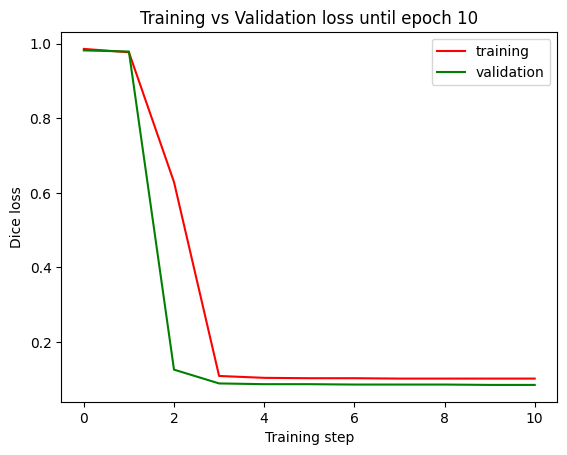


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0929: 100%|████████████████████████████████████████████████████████████| 591/591 [04:32<00:00,  2.17it/s]



VALIDATION starts!



validation loss: 0.0854: 100%|██████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.05it/s]


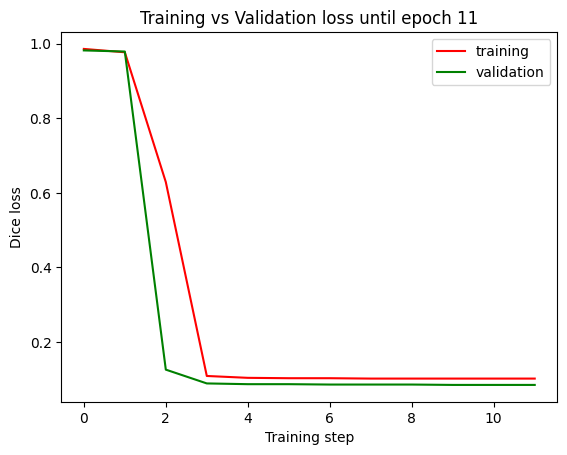

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.08it/s]



 Dice score on test set: 0.9021




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:32<00:00,  6.10it/s]



 Dice score on validation set: 0.914663342352446



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [01:37<00:00,  6.08it/s]



 Dice score on train set: 0.8981207517399602


In [20]:
unet_taskC_3levels = train_and_evaluate_on_task(
    "C",
    unet_size=3,
    ablation=True,
)

torch.save(unet_taskC_3levels.module.state_dict(), f"ablation_checkpoints/UNET_taskC_3level.pth")


****************** Epoch - 0 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9998: 100%|████████████████████████████████████████████████████████████| 591/591 [05:26<00:00,  1.81it/s]



VALIDATION starts!



validation loss: 0.9896: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.49it/s]


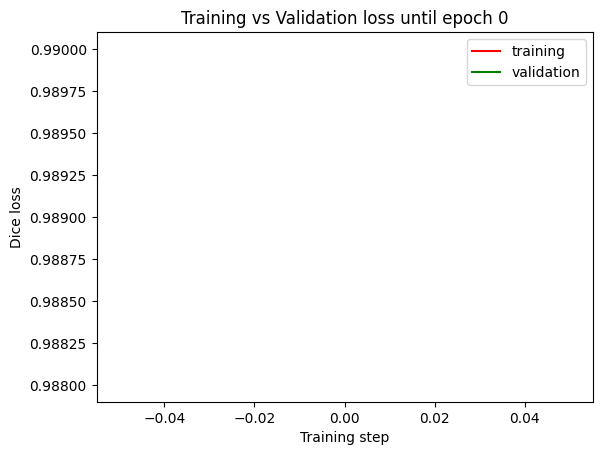


****************** Epoch - 1 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.7706: 100%|████████████████████████████████████████████████████████████| 591/591 [05:26<00:00,  1.81it/s]



VALIDATION starts!



validation loss: 0.8576: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.48it/s]


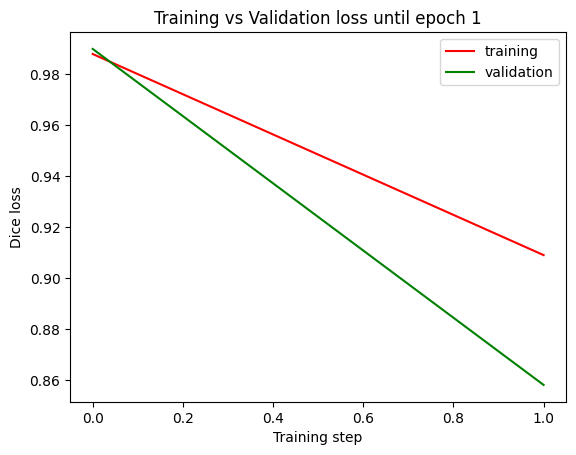


****************** Epoch - 2 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5238: 100%|████████████████████████████████████████████████████████████| 591/591 [05:33<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.4566: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.50it/s]


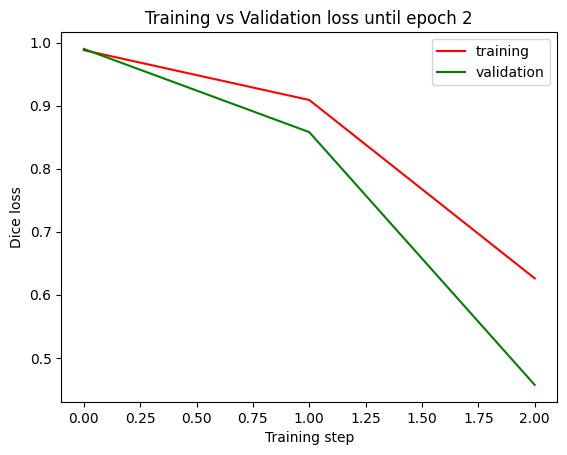


****************** Epoch - 3 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.3053: 100%|████████████████████████████████████████████████████████████| 591/591 [05:25<00:00,  1.82it/s]



VALIDATION starts!



validation loss: 0.2865: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.48it/s]


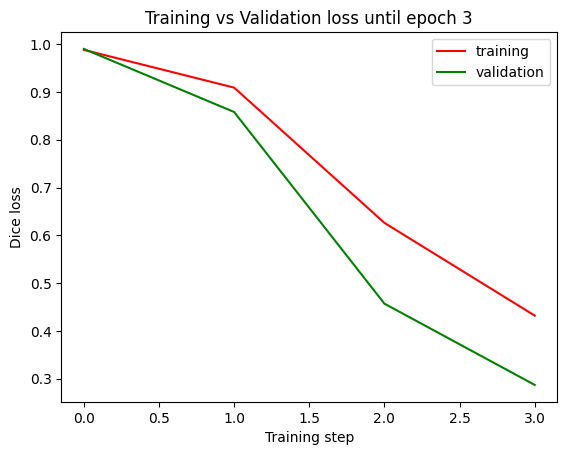


****************** Epoch - 4 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.2245: 100%|████████████████████████████████████████████████████████████| 591/591 [05:32<00:00,  1.78it/s]



VALIDATION starts!



validation loss: 0.1001: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.50it/s]


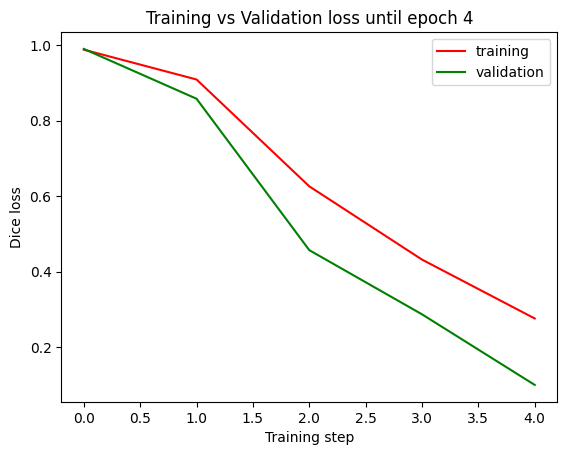


****************** Epoch - 5 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0632: 100%|████████████████████████████████████████████████████████████| 591/591 [05:25<00:00,  1.82it/s]



VALIDATION starts!



validation loss: 0.0866: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.48it/s]


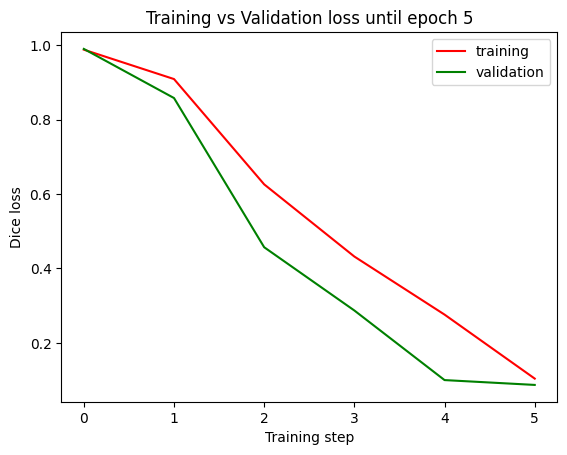


****************** Epoch - 6 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0005: 100%|████████████████████████████████████████████████████████████| 591/591 [05:25<00:00,  1.81it/s]



VALIDATION starts!



validation loss: 0.0890: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.49it/s]


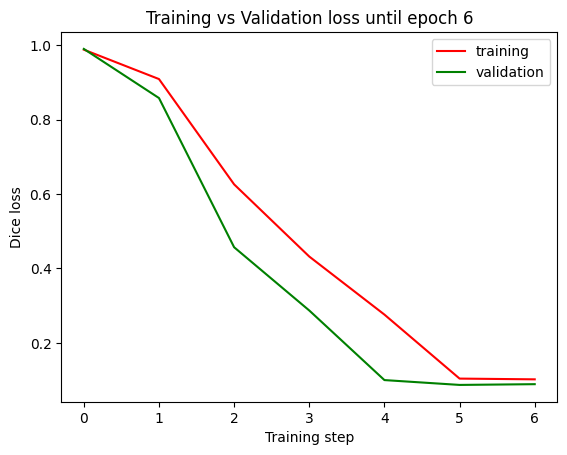


****************** Epoch - 7 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1252: 100%|████████████████████████████████████████████████████████████| 591/591 [05:25<00:00,  1.81it/s]



VALIDATION starts!



validation loss: 0.0857: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.51it/s]


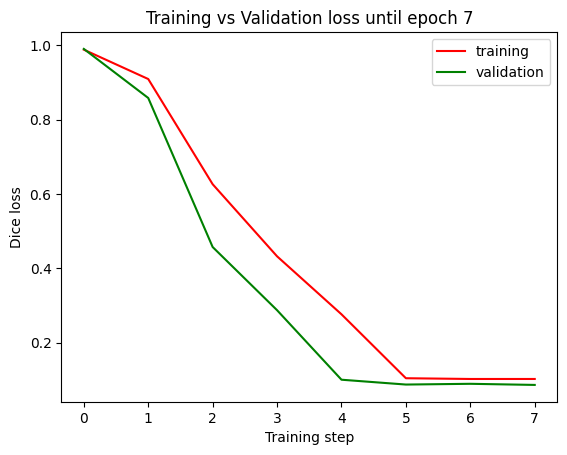


****************** Epoch - 8 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0937: 100%|████████████████████████████████████████████████████████████| 591/591 [05:33<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.0855: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.48it/s]


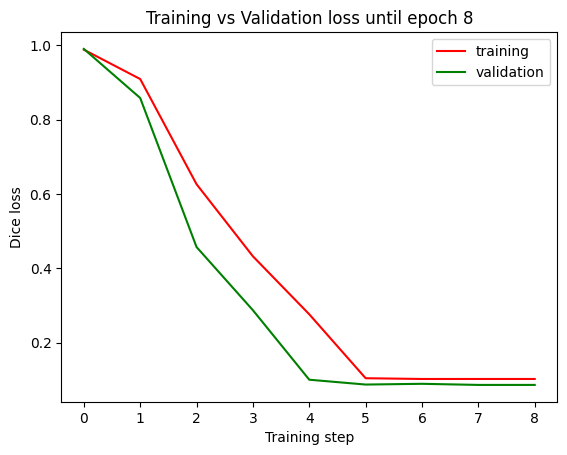


****************** Epoch - 9 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0625: 100%|████████████████████████████████████████████████████████████| 591/591 [05:33<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.0890: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.50it/s]


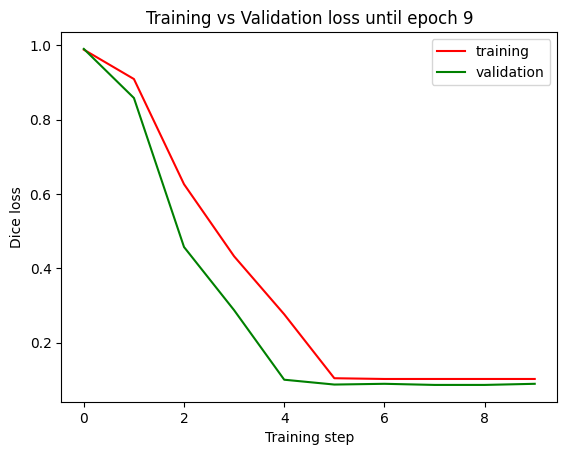


****************** Epoch - 10 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.1554: 100%|████████████████████████████████████████████████████████████| 591/591 [05:32<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.0857: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.51it/s]


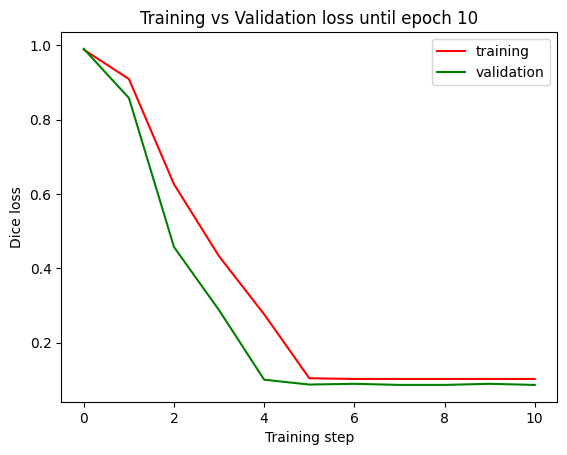


****************** Epoch - 11 *******************




  0%|                                                                                             | 0/591 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.0936: 100%|████████████████████████████████████████████████████████████| 591/591 [05:33<00:00,  1.77it/s]



VALIDATION starts!



validation loss: 0.0864: 100%|██████████████████████████████████████████████████████████| 197/197 [00:43<00:00,  4.52it/s]


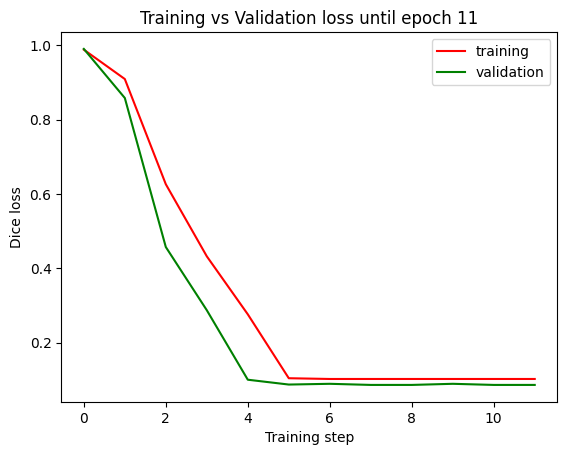

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:41<00:00,  4.70it/s]



 Dice score on test set: 0.9009




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 197/197 [00:41<00:00,  4.71it/s]



 Dice score on validation set: 0.9136611940291932



Evaluation on TRAIN set!



100%|███████████████████████████████████████████████████████████████████████████████████| 591/591 [02:05<00:00,  4.70it/s]



 Dice score on train set: 0.8972751800784


In [21]:
unet_taskC_4levels = train_and_evaluate_on_task(
    "C",
    unet_size=4,
    ablation=True
)

torch.save(unet_taskC_4levels.module.state_dict(), f"ablation_checkpoints/UNET_taskC_4level.pth")

### Ablation 2: Learning rate (2e-4 vs 2e-6)
This would help us check if our intially chosen 2e-4 learning rate was optimal or not.

**We find that training a 4-level UNet with learning rate 2e-6 results in dice score of 0.44 on TASK A test set, whereas we earlier got dice score of 0.83 on test set with the same model trained using learning rate of 2e-4. This shows that we chose a pretty-optimal estimate of learning rate**


****************** Epoch - 0 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6954: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.7297: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


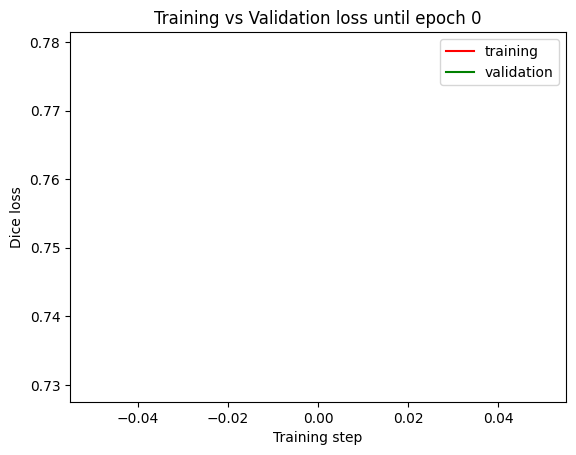


****************** Epoch - 1 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.7001: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:55<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.7115: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


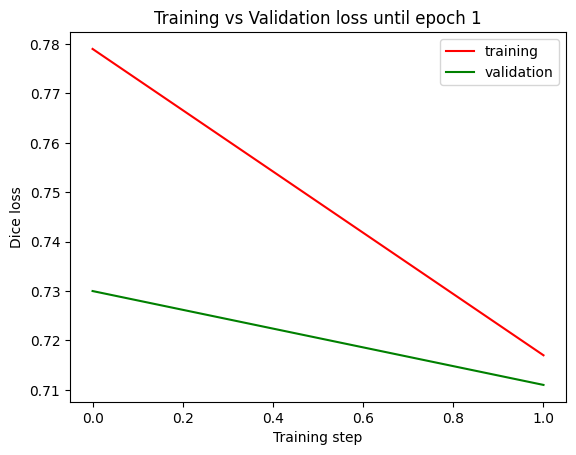


****************** Epoch - 2 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6954: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.6876: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


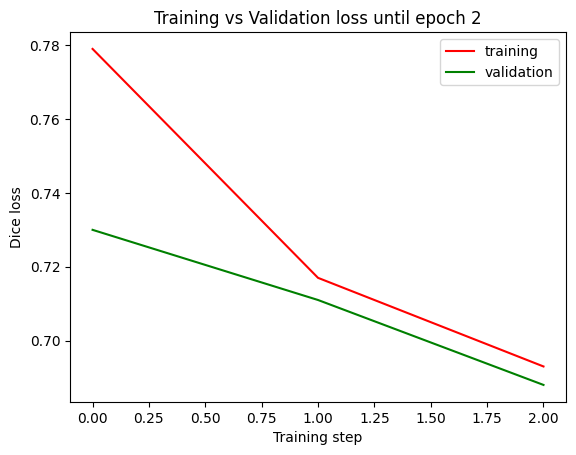


****************** Epoch - 3 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6458: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.6541: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.40it/s]


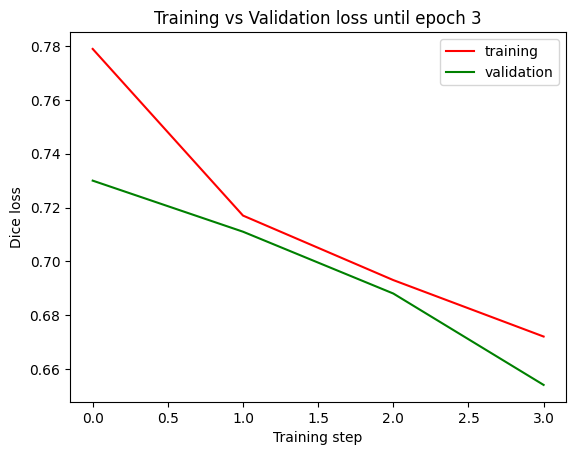


****************** Epoch - 4 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6592: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.6347: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


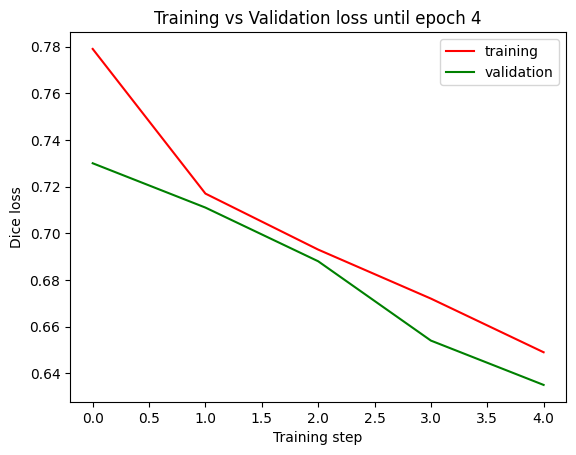


****************** Epoch - 5 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6071: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:53<00:00,  2.13it/s]



VALIDATION starts!



validation loss: 0.6652: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


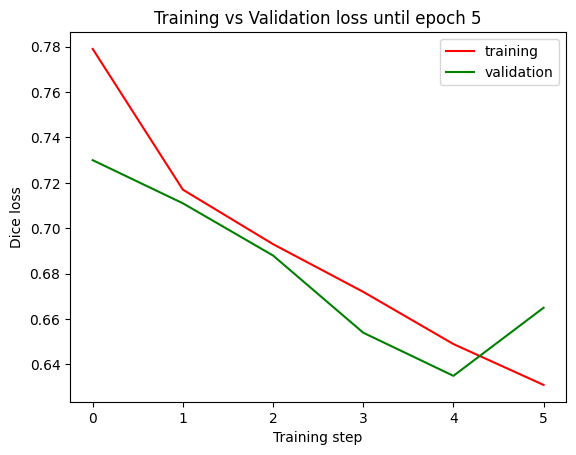


****************** Epoch - 6 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5203: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.6087: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


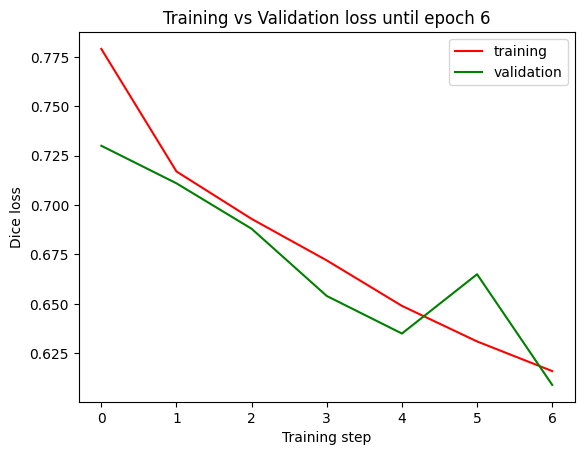


****************** Epoch - 7 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6045: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.6105: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


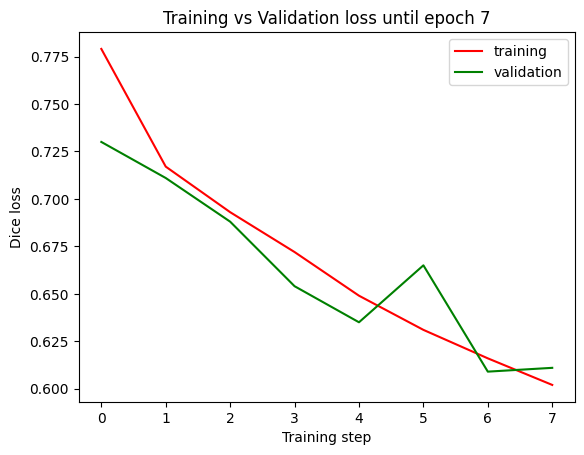


****************** Epoch - 8 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5574: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.5828: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


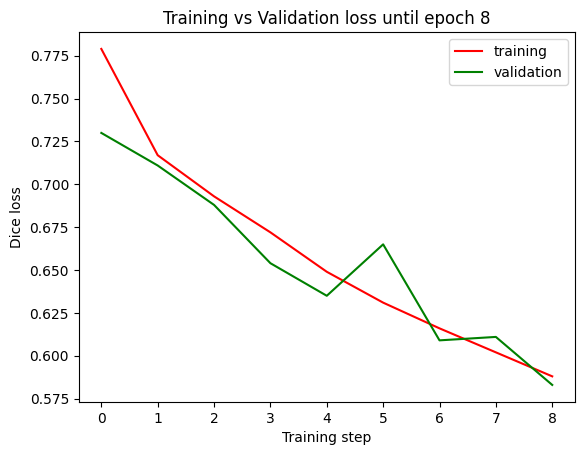


****************** Epoch - 9 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5472: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.5678: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


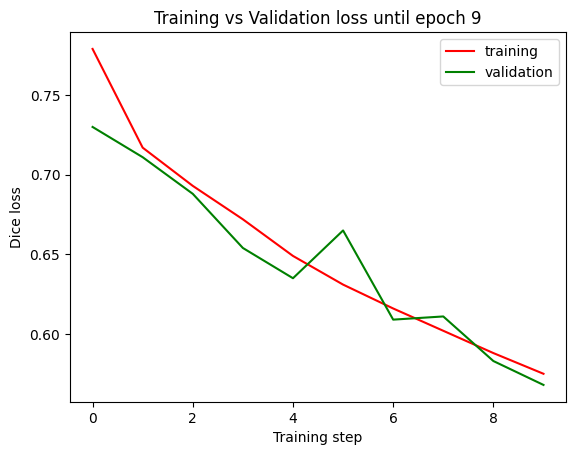


****************** Epoch - 10 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.5506: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.5990: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


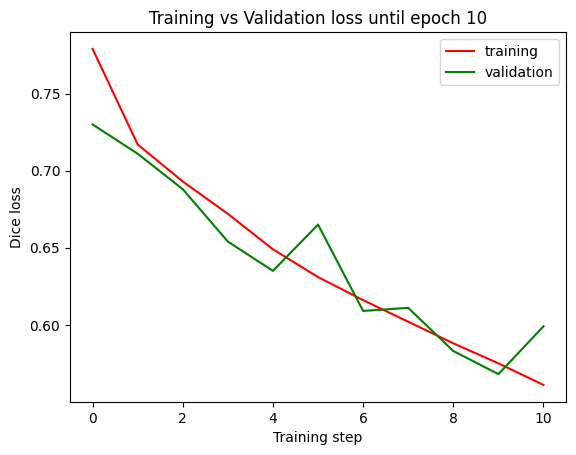


****************** Epoch - 11 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.6198: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.5546: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


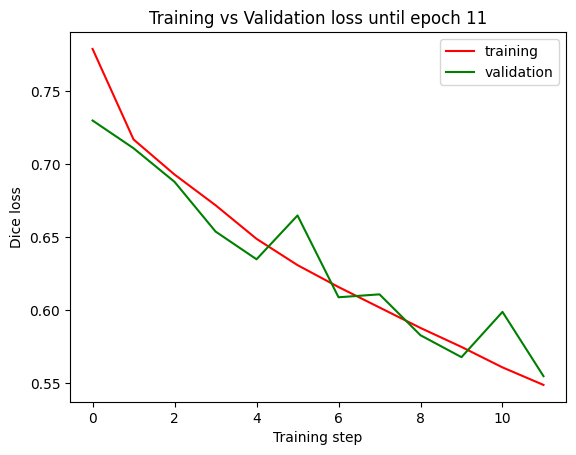

Validation loss degraded after patience limit! Stopping training

*************** STARTING EVALUATION ***************


Evaluation on TEST set!



100%|███████████████████████████████████████████████████████████████████████████████████| 590/590 [01:31<00:00,  6.44it/s]



 Dice score on test set: 0.4452




Evaluation on VALIDATION set!



100%|███████████████████████████████████████████████████████████████████████████████████| 590/590 [01:31<00:00,  6.44it/s]



 Dice score on validation set: 0.44538949725486465



Evaluation on TRAIN set!



100%|█████████████████████████████████████████████████████████████████████████████████| 1772/1772 [04:35<00:00,  6.44it/s]



 Dice score on train set: 0.4678481344562486


In [11]:
unet_taskA_4levels = train_and_evaluate_on_task(
    "A",
    unet_size=4,
    ablation=True,
    lr=2e-6,
    batch_size=16 # Had to reduce batch size as someone else was also using the GPUs on the server
)

torch.save(unet_taskA_4levels.state_dict(), f"ablation_checkpoints/UNET_taskA_4level_2e-6lr.pth")


****************** Epoch - 0 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9997: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.9990: 100%|██████████████████████████████████████████████████████████| 590/590 [01:31<00:00,  6.43it/s]


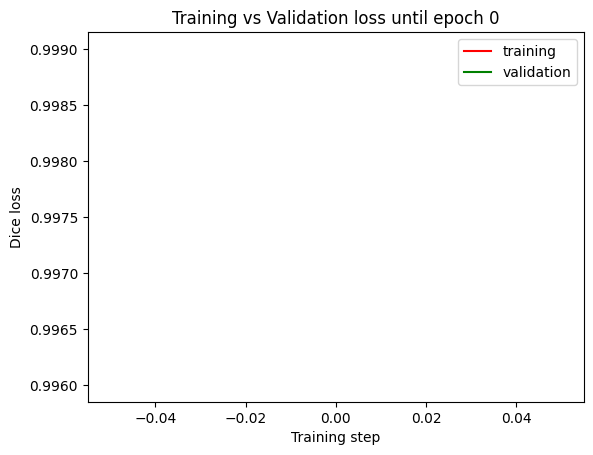


****************** Epoch - 1 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9860: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.9958: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


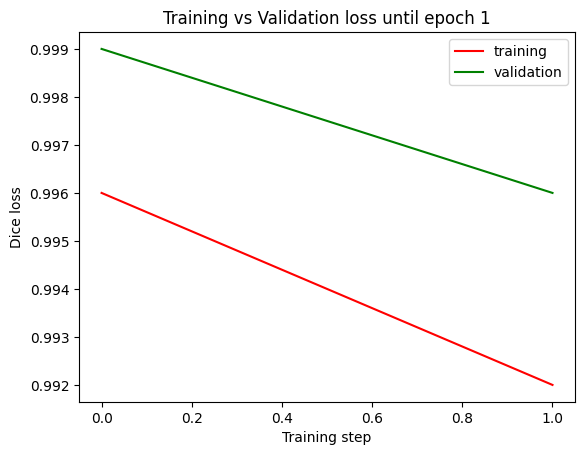


****************** Epoch - 2 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9999: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:54<00:00,  2.12it/s]



VALIDATION starts!



validation loss: 0.9945: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


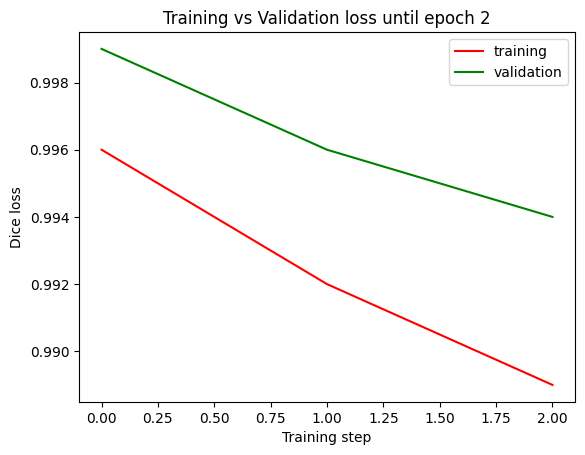


****************** Epoch - 3 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9902: 100%|██████████████████████████████████████████████████████████| 1772/1772 [13:53<00:00,  2.13it/s]



VALIDATION starts!



validation loss: 0.9933: 100%|██████████████████████████████████████████████████████████| 590/590 [01:32<00:00,  6.41it/s]


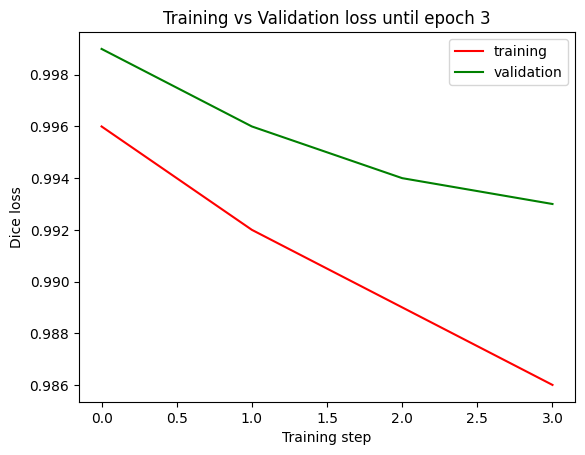


****************** Epoch - 4 *******************




  0%|                                                                                            | 0/1772 [00:00<?, ?it/s]


TRAINING starts!



training loss: 0.9924:  76%|███████████████████████████████████████████▊              | 1339/1772 [10:30<03:23,  2.12it/s]

In [ ]:
unet_taskB_4levels = train_and_evaluate_on_task(
    "B",
    unet_size=4,
    ablation=True,
    lr=2e-6, 
    batch_size=16 # Had to reduce batch size as someone else was also using the GPUs on the server,
)

torch.save(unet_taskB_4levels.state_dict(), f"ablation_checkpoints/UNET_taskB_4level_2e-6lr.pth")

In [ ]:
unet_taskC_4levels = train_and_evaluate_on_task(
    "C",
    unet_size=4,
    ablation=True,
    lr=2e-6,  # Had to reduce batch size as someone else was also using the GPUs on the server
)

torch.save(unet_taskC_4levels.state_dict(), f"ablation_checkpoints/UNET_taskC_4level_2e-6lr.pth")

## Visualize segmentations of best model

In [12]:
os.listdir("FOLD0/10522") # We want visuals for this case, only present in FOLD0

['10522_1000532_adc.mha',
 '10522_1000532_hbv.mha',
 '10522_1000532_t2w.mha',
 '10522_1000532_sag.mha',
 '10522_1000532_cor.mha']

In [13]:
def visualize_segmentations(TASK):
    
    if TASK == "A":

        type_of_volume="t2w" 
        type_of_mask="PROSTATE"
        LABEL_DIR = "picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/"
    
    elif TASK == "B":

        type_of_volume="adc"
        type_of_mask="LESION"
        LABEL_DIR = "picai_labels/csPCa_lesion_delineations/AI/Bosma22a/"
    
    elif TASK == "C":

        type_of_volume="hbv"
        type_of_mask="LESION"
        LABEL_DIR = "picai_labels/csPCa_lesion_delineations/AI/Bosma22a/"
    
    img_path = f"FOLD0/10522/10522_1000532_{type_of_volume}.mha"
    label_path = LABEL_DIR + "10522_1000532.nii.gz"
    
    device = "cuda:2"

    images, masks = IMAGE_PIPELINE(img_path, label_path, REF_SPACING)
    
    images = torch.from_numpy(np.concatenate(images)).unsqueeze(1).float().to(device)
    masks = torch.from_numpy(np.concatenate(masks)).unsqueeze(1).float().to(device)
    
    unet = UNet_4level().to(device)
    unet.load_state_dict(torch.load(f"ablation_checkpoints/UNET_task{TASK}_4level.pth"))
    unet.eval()

    #x_img, y_mask = next(iter(test_loader))
    #x_img = x_img.unsqueeze(1).float().to(device)
    #y_mask = y_mask.unsqueeze(1).float().to(device)

    with torch.no_grad():
        y_pred = unet(images)
        
    return images, y_pred, masks

In [72]:
images, y_pred, masks = visualize_segmentations("A")

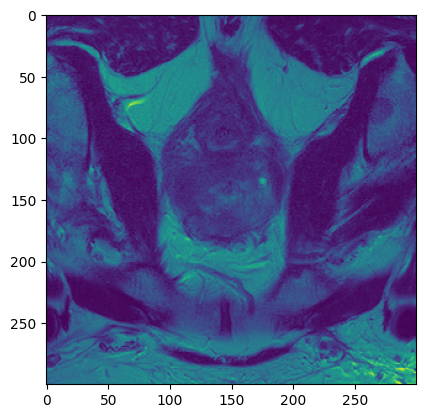

In [73]:
plt.imshow(images[9][0].cpu().numpy()) # Input image

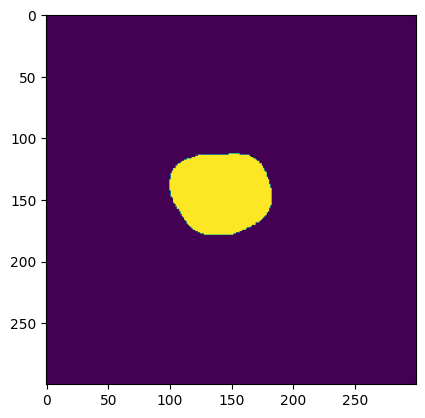

In [74]:
plt.imshow(masks[9][0].cpu().numpy()) # True mask (ground truth target)

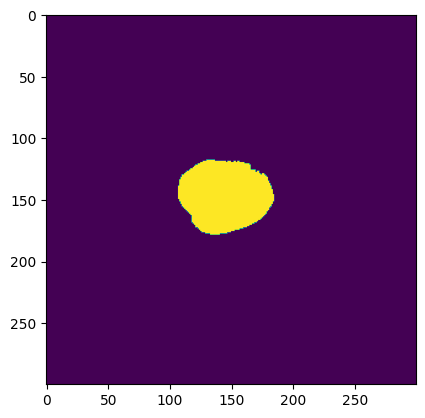

In [75]:
plt.imshow(torch.round(y_pred).cpu().numpy()[9][0]) # Predicted mask (model prediction)

In [53]:
images, y_pred, masks = visualize_segmentations("B")

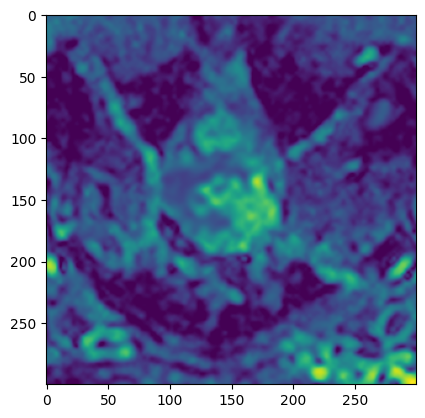

In [54]:
plt.imshow(images[9][0].cpu().numpy()) # Input image

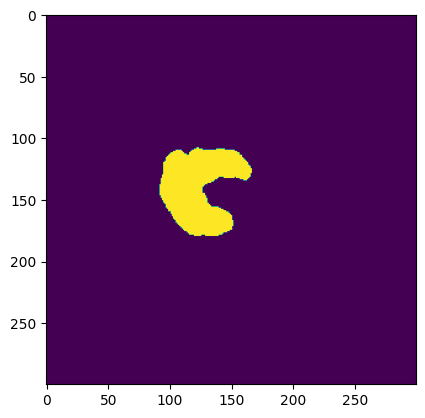

In [55]:
plt.imshow(masks[9][0].cpu().numpy()) # True mask (ground truth target)

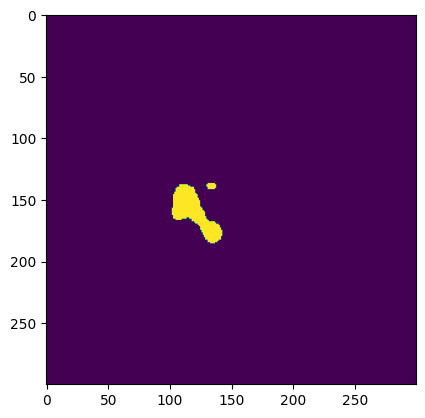

In [58]:
plt.imshow(torch.round(y_pred).cpu().numpy()[9][0]) # Predicted mask (model prediction)

In [59]:
images, y_pred, masks = visualize_segmentations("C")

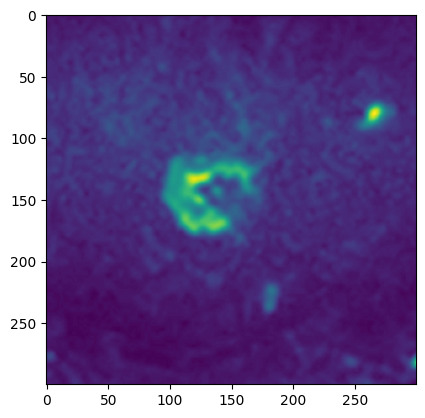

In [60]:
plt.imshow(images[9][0].cpu().numpy()) # Input image

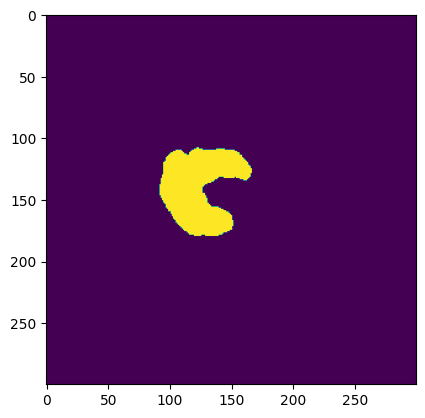

In [61]:
plt.imshow(masks[9][0].cpu().numpy()) # True mask (ground truth target)

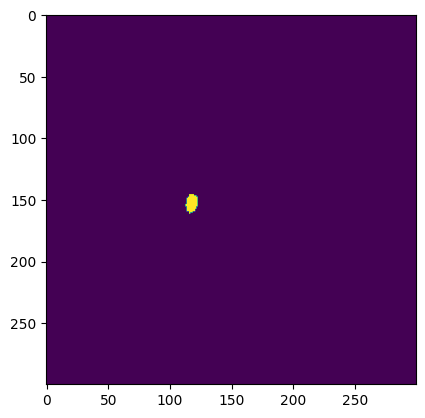

In [71]:
plt.imshow(torch.round(y_pred).cpu().numpy()[10][0]) # Predicted mask (model prediction)